In [1]:
import os
from joblib import Parallel, delayed
import time
import numpy as np
import pickle
import pylab as pl


In [2]:
total_count = 48


In [3]:


def getTimesThputs(file):
    f = open(file, "r")
    data = f.readlines() 
    times = []
    thputs = []
    latencies = []
    for line in data:
        if not line.startswith('--') and 'current ops/sec; [UPDATE AverageLatency' in line:

#         print(line)
            times.append(line.split('sec:')[0].strip())
            thputs.append(line.split(';')[1].split('current')[0].strip())
            latencies.append(line.split('=')[1].split(']')[0].strip())
            
            print(line,latencies[-1],thputs[-1],times[-1])

    return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)/1e6  






def getTimeThps(file, flag):
    
    f = open(file, "r")
    data = f.readlines() 

    times = []
    thputs = []
    for line in data:
        if 'throughput[ops/s]' in line:
            lineData = (line[13+line.find('max[ops/s])>'):-2])
            print(lineData)

            times.append(lineData.split('|')[0])
            thputs.append(lineData.split('|')[-2])
    if (flag): 
        times.append(float(times[-1])+abs(float(times[-1]) - float(times[-2]) ))
        thputs.append(0)
        
    return np.array(times).astype(float), np.array(thputs).astype(float) 

In [4]:
# os.system("aws --region us-west-2 ec2 describe-instances  --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PrivateIpAddress]' --output text > all_internal_ips")

# os.system("aws --region us-west-2 ec2 describe-instances --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips")



# os.system("aws --region us-west-2 ec2 describe-instances  --query 'Reservations[*].Instances[*].[PrivateIpAddress]' --output text > all_internal_ips")

# os.system("aws --region us-west-2 ec2 describe-instances  --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips")

In [5]:
with open('all_external_ips') as f:
    lines = f.read().splitlines()


lines = [x for x in lines if x!='None']
lines, len(lines)

(['54.70.72.178',
  '35.90.237.144',
  '34.209.237.206',
  '35.88.224.135',
  '52.43.199.26',
  '18.237.131.187',
  '54.200.40.42',
  '34.212.174.11',
  '34.213.100.22',
  '54.245.65.7',
  '54.149.25.141',
  '54.244.212.2',
  '35.88.224.17',
  '34.213.170.38',
  '54.200.234.124',
  '35.90.120.172',
  '35.92.32.214',
  '34.216.195.92',
  '35.164.133.40',
  '18.236.217.172',
  '34.211.238.95',
  '34.221.58.231',
  '18.236.230.52',
  '35.91.38.114',
  '34.215.84.42',
  '54.190.24.225',
  '54.184.177.95',
  '18.237.43.220',
  '54.212.185.238',
  '35.92.178.4',
  '35.90.164.115',
  '54.189.62.190',
  '34.212.229.116',
  '34.209.154.200',
  '34.222.80.244',
  '52.10.94.142',
  '35.91.20.164',
  '35.89.200.196',
  '34.209.128.247',
  '18.246.76.214',
  '35.89.51.131',
  '52.10.121.237',
  '35.90.155.197',
  '18.237.228.252',
  '54.201.158.211',
  '35.90.128.59',
  '35.165.175.113',
  '54.68.124.173',
  '35.92.39.20',
  '52.88.104.210',
  '18.236.66.69',
  '34.219.142.213'],
 52)

In [6]:
for ip in lines:
    if ip!='None':
        current = (ip.split('.'))

        print('ssh -i "FinalKeys.pem" ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com')

ssh -i "FinalKeys.pem" ubuntu@ec2-54-70-72-178.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-35-90-237-144.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-34-209-237-206.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-35-88-224-135.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-52-43-199-26.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-18-237-131-187.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-54-200-40-42.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-34-212-174-11.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-34-213-100-22.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-54-245-65-7.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-54-149-25-141.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-54-244-212-2.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-35-88-224-

In [7]:
## Set number of clusters

nclusters = 0

for folder in os.listdir('.'):
    if 'config' in folder and folder!='config':
        nclusters = nclusters + 1
        
        
print(nclusters)




nreplicas = int(total_count/nclusters)
nodeIps = lines[:nclusters* nreplicas]

nclients = nclusters

# no_cluster_yet_nodes = lines[nclusters* nreplicas:-(nclusters)]
no_cluster_yet_nodes = lines[nclusters* nreplicas:-nclients]



# clientIps = lines[-(nclusters):]
clientIps = lines[-nclients:]



clientIps, no_cluster_yet_nodes

4


(['35.92.39.20', '52.88.104.210', '18.236.66.69', '34.219.142.213'], [])

In [8]:
## Functions

def setup(i):

    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKU2.pem '+'commands.sh'+' ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-2.compute.amazonaws.com:commands.sh'
        
        print(command)
        os.system(command)
        
def initialize(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKU2.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-2.compute.amazonaws.com -t "sudo sh commands.sh"'
        
        
        os.system(command)
        
        
def git_clone(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKU2.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-2.compute.amazonaws.com -t " sudo git clone https://github.com/tmane002/BftSmart_Final.git"'
        
        
        os.system(command)
        
def git_pull(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKU2.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-2.compute.amazonaws.com -t "git config --global --add safe.directory /home/ubuntu/BftSmart_Final; cd BftSmart_Final; sudo git pull"'
        
        
        os.system(command)
        
def compile_job(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKU2.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-2.compute.amazonaws.com -T "cd BftSmart_Final; sudo ./gradlew installDist"'
        
        
        os.system(command)

        
        
def clean_job(i):
    ip = lines[i]
    
    rm_command = 'sudo rm config/currentView; '
    for iter_ in range(nclusters):
        rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '
        
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKU2.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-2.compute.amazonaws.com -T "sudo rm nohup.out; cd BftSmart_Final; '+rm_command+'"'
        
        
        os.system(command)
        
        
def clean_all(i):
    ip = lines[i]
    
    rm_command = 'sudo rm -r BftSmart_Final; sudo rm nohup.out;sudo rm nohup_client.out;'

        
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKU2.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-2.compute.amazonaws.com -T "sudo rm nohup.out; '+rm_command+'"'
        
        
        os.system(command)
        
def run_server_node(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKU2.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-2.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        os.system(command)
        
        
        
    if ip!='None' and( ip in no_cluster_yet_nodes):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKU2.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-2.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        os.system(command)        
#         print(command)

def check_node(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -f -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKU2.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-2.compute.amazonaws.com -T "tail -n 1000 nohup.out"'
        
        
        os.system(command)
#         print(command)


def run_basic_client(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
#     if ip!='None' and ip in nodeIps[1:1+len(clientIps)]:
        
        current = (ip.split('.'))
        
#         cmd_arg = nodeIps[1:1+len(clientIps)].index(ip)
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKU2.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-2.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'

        
        os.system(command)


def kill_java(i):
    ip = lines[i]
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKU2.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-2.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'
        
        
        os.system(command)
        
        
        
def kill_clients(i):
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKU2.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-2.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'
        
        
        os.system(command)

def run_server_node_check(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKU2.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-2.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        print(command)
        
        

# for i in range(len(lines)):
#     run_server_node_check(i)

def run_basic_client_check(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKU2.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-2.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'

        
        print(command)

In [9]:
# for i in range(len(lines)):
#     run_basic_client_check(i)
    

# def setup(i):

#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'commands.sh'+' ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:commands.sh'
        
        
#         os.system(command)
        
# def initialize(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t "sudo sh commands.sh"'
        
        
#         os.system(command)
        
        
# def git_clone(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t " sudo git clone https://tmane002@bitbucket.org/tmane002/BftSmart_Final.git"'
        
        
#         os.system(command)
        
# def git_pull(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t "git config --global --add safe.directory /home/ubuntu/bftsmartt; cd bftsmartt; sudo git pull"'
        
        
#         os.system(command)
        
# def compile_job(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo ./gradlew installDist"'
        
        
#         os.system(command)

        
        
# def clean_job(i):
#     ip = lines[i]
    
#     rm_command = 'sudo rm config/currentView; '
#     for iter_ in range(nclusters):
#         rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '
        
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "sudo rm nohup.out; cd bftsmartt; '+rm_command+'"'
        
        
#         os.system(command)
        
        
# def clean_all(i):
#     ip = lines[i]
    
#     rm_command = 'sudo rm -r bftsmartt; sudo rm nohup.out;sudo rm nohup_client.out;'

        
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "sudo rm nohup.out; '+rm_command+'"'
        
        
#         os.system(command)
        
# def run_server_node(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
#     if ip!='None' and( ip in nodeIps):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         os.system(command)
        
        
        
#     if ip!='None' and( ip in no_cluster_yet_nodes):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         os.system(command)        
# #         print(command)

# def check_node(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -f -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "tail -n 1000 nohup.out"'
        
        
#         os.system(command)
# #         print(command)


# def run_basic_client(i):
#     cmd_arg = ''
    
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
# #     if ip!='None' and ip in nodeIps[1:1+len(clientIps)]:
        
#         current = (ip.split('.'))
        
# #         cmd_arg = nodeIps[1:1+len(clientIps)].index(ip)
        
#         for iter__ in range(len(clientIps)):
#             if ip==clientIps[iter__]:
#                 cmd_arg = iter__
                
                
        
# #         print(i, cmd_arg)
            
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmartt; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'

        
#         os.system(command)


# def kill_java(i):
#     ip = lines[i]
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo killall java; sudo killall nohup"'
        
        
#         os.system(command)
        
        
        
# def kill_clients(i):
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo killall java; sudo killall nohup"'
        
        
#         os.system(command)

# def run_server_node_check(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
#     if ip!='None' and( ip in nodeIps):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         print(command)
        
        

# # for i in range(len(lines)):
# #     run_server_node_check(i)

# def run_basic_client_check(i):
#     cmd_arg = ''
    
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
        
#         for iter__ in range(len(clientIps)):
#             if ip==clientIps[iter__]:
#                 cmd_arg = iter__
                
                
        
# #         print(i, cmd_arg)
            
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmartt; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'

        
#         print(command)

# # for i in range(len(lines)):
# #     run_basic_client_check(i)
    

In [10]:
## First Time Setup

lines, len(lines)

(['54.70.72.178',
  '35.90.237.144',
  '34.209.237.206',
  '35.88.224.135',
  '52.43.199.26',
  '18.237.131.187',
  '54.200.40.42',
  '34.212.174.11',
  '34.213.100.22',
  '54.245.65.7',
  '54.149.25.141',
  '54.244.212.2',
  '35.88.224.17',
  '34.213.170.38',
  '54.200.234.124',
  '35.90.120.172',
  '35.92.32.214',
  '34.216.195.92',
  '35.164.133.40',
  '18.236.217.172',
  '34.211.238.95',
  '34.221.58.231',
  '18.236.230.52',
  '35.91.38.114',
  '34.215.84.42',
  '54.190.24.225',
  '54.184.177.95',
  '18.237.43.220',
  '54.212.185.238',
  '35.92.178.4',
  '35.90.164.115',
  '54.189.62.190',
  '34.212.229.116',
  '34.209.154.200',
  '34.222.80.244',
  '52.10.94.142',
  '35.91.20.164',
  '35.89.200.196',
  '34.209.128.247',
  '18.246.76.214',
  '35.89.51.131',
  '52.10.121.237',
  '35.90.155.197',
  '18.237.228.252',
  '54.201.158.211',
  '35.90.128.59',
  '35.165.175.113',
  '54.68.124.173',
  '35.92.39.20',
  '52.88.104.210',
  '18.236.66.69',
  '34.219.142.213'],
 52)

In [11]:
results = Parallel(n_jobs=len(lines))(delayed(setup)(i) for i in range(len(lines)))
print(results)  

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [12]:
results = Parallel(n_jobs=len(lines))(delayed(initialize)(i) for i in range(len(lines)))
print(results)  

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSma

Hit:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://us-west-2.ec2.arch

fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
Cloning into 'BftSmart_Final'...


Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease


fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.


Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Reading package lists...Reading package lists...Reading package lists...Reading package lists...Reading package lists...Reading package lists...Reading package lists...Reading package lists...
Reading package lists...
Building dependency tree...



Reading package lists...Reading package lists...
Building dependency tree...Reading package lists...
Building dependency tree...
Building dependency tree...Reading package lists...
Building dependency tree...


Reading state information...
Reading package lists...
Reading package lists...Building dependency tree...

Building dependency tree...
Reading state information...

Reading state information...

Reading state information...
Reading package lists...
Building dependency tree...
Reading state information...
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Reading package lists...
Building dependency

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


curl is already the newest version (7.81.0-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Reading package lists...
Building dependency tree...Reading package lists...
Reading package lists...Building dependency tree...Reading package lists...
Building dependency tree...
Reading package lists...Building dependency tree...
Building dependency tree...curl is already the newest version (7.81.0-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.


job.sh: 11: sdk: not found
job.sh: 11: sdk: not found



Reading state information...
Reading package lists...
Building dependency tree...
Reading state information...
Reading package lists...
Reading state information...


Reading state information...
Building dependency tree...Hit:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]

Reading state information...
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.

Reading state information...


job.sh: 11: sdk: not found


The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre libasound2-plugins
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
  alsa-utils cups-common liblcms2-utils pcscd libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic
The following additional packages w

Building dependency tree...
Reading state information...

Reading state information...
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Get:15 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 openjdk-11-jre-headless amd64 11.0.19+7~us1-0ubuntu1~22.04.1 [42.5 MB]
Reading package lists...
Building dependency tree...
Reading state information...

Reading state information...
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: 'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: 

ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.

Reading state information...
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Reading package lists...iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.

Building dependency tree...Get:6 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.


[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: 'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: 

Get:7 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:8 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:9 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:10 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:11 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [792 kB]

Reading state information...Get:12 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [200 kB]

Get:13 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f Metadata [15.4 kB]
Get:14 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [567 kB]
Get:15 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted Translation-en [88.2 kB]
Get:16 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: 'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Get:19 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c-n-f Metadata [20.7 kB]
Get:20 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [41.6 kB]
Get:21 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse Translation-en [9704 B]
Get:22 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 c-n-f Metadata [476 B]
Get:23 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-backports/main amd64 Packages [40.9 kB]
Get:24 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-backports/main Translation-en [10.2 kB]
Get:25 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-backports/main amd64 c-n-f Metadata [388 B]
Get:26 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-backports/restricted amd64 c-n-f Metadata [116 B]
Get:27 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe amd64 Packages [22.2 kB]
Get:28 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy

[sudo] password for tejas: [sudo] password for tejas: Pseudo-terminal will not be allocated because stdin is not a terminal.
[sudo] password for tejas: [sudo] password for tejas: Pseudo-terminal will not be allocated because stdin is not a terminal.
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Pseudo-terminal will not be allocated because stdin is not a terminal.
[sudo] password for tejas: Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.


Get:16 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Get:18 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]
Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [140 kB]
Get:33 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.0 kB]
Get:34 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [560 kB]


Pseudo-terminal will not be allocated because stdin is not a terminal.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.


Get:16 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [87.4 kB]
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [750 kB]
Get:18 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]
Fetched 46.3 MB in 1s (36.3 MB/s)
Selecting previously unselected package alsa-topology-conf.
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [134 kB]
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [15.8 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Get:41 http://s

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be all

Selecting previously unselected package ca-certificates-java.
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.2_all.deb ...
Unpacking ca-certificates-java (20190909ubuntu1.2) ...
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...
Selecting previously unselected package libasound2-data.
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package libasound2:amd64.
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package java-common.
Selecting previously unselected package alsa-ucm-conf.
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.7_all.deb ...
Unpacking java-common (

Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo

Selecting previously unselected package libavahi-common3:amd64.
Selecting previously unselected package ca-certificates-java.
Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5.1_amd64.deb ...
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.2_all.deb ...
Unpacking libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Unpacking ca-certificates-java (20190909ubuntu1.2) ...
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../08-libavahi-client3_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Unpacking java-common (0.72build2) ...
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 46.3 MB in 3s (17.1 MB/s)
Selecting previously unselected package alsa-topology-conf.
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...
Selecting previously unselected package libasound2-data.
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package libasound2:amd64.
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package alsa-ucm-conf.
Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.7_all.deb ...
Unpacking alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Selecting previously unselected package ca-certificates-java.
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.2_all.deb ...
Unpacking ca-certificates-java (20190909ubuntu1.2)

Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...


Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../08-libavahi-client3_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...


Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...


Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../10-liblcms2-2_2.12~rc1-2build2_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.12~rc1-2build2) ...
Selecting previously unselected package libgraphite2-3:amd64.
Preparing to unpack .../11-libgraphite2-3_1.3.14-1build2_amd64.deb ...


Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...


Unpacking libgraphite2-3:amd64 (1.3.14-1build2) ...
Selecting previously unselected package libharfbuzz0b:amd64.
Preparing to unpack .../12-libharfbuzz0b_2.7.4-1ubuntu3.1_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Selecting previously unselected package libpcsclite1:amd64.
Preparing to unpack .../13-libpcsclite1_1.9.5-3_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.9.5-3) ...
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../14-openjdk-11-jre-headless_11.0.19+7~us1-0ubuntu1~22.04.1_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.19+7~us1-0ubuntu1~22.04.1) ...


Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...


Hit:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease


Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
Cloning into 'BftSmart_Final'...


Hit:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists...

Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
hostfile_replace_entries: link /root/.ssh/known_hosts to /root/.ssh/known_hosts.old: File exists
update_known_hosts: hostfile_replace_entries failed for /root/.ssh/known_hosts: File exists
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...


Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Reading package lists...Reading package lists...Reading package lists...Selecting previously unselected package default-jre-headless.
Preparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...
Unpacking default-jre-headless (2:1.11-72build2) ...


Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...


Selecting previously unselected package ant.
Preparing to unpack .../16-ant_1.10.12-1_all.deb ...

Reading package lists...
Building dependency tree...Selecting previously unselected package default-jre-headless.
Preparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...
Unpacking default-jre-headless (2:1.11-72build2) ...
Unpacking ant (1.10.12-1) ...
Selecting previously unselected package ant-optional.
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Unpacking ant-optional (1.10.12-1) ...
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Selecting previously unselected package ant.

Reading state information...Preparing to unpack .../16-ant_1.10.12-1_all.deb ...

Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Setting up java-common (0.72build2) ...
Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Setting up libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Setting up libpcsclite1:amd64 (1.9.5-3) ...

Setting up alsa-topology-conf (1.2.5.1-2) .

job.sh: 11: sdk: not found


Get:4 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]

Reading state information...
Hit:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:3 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
curl is already the newest version (7.81.0-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Hit:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://us-west-2.ec2.archive

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:5 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]

Reading state information...
Get:4 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]

Reading state information...
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Reading package lists...
Reading state information...

Get:4 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Building dependency tree...Hit:

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:Security_Communication_Root_CA.pemGet:5 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Adding debian:DigiCert_Assured_ID_Root_G3.pem
Get:7 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]

Reading state information...

Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:GlobalSign_Root_E46.pemGet:8 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]

Get:9 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Adding debian:Certigna_Root_CA.pem
Adding debian:ACCVRAIZ1.pem
Get:10 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Ge

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Get:6 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Adding debian:SecureTrust_CA.pem
Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debian:EC-ACC.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:Staat_der_Nederlanden_EV_Root_CA.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:AffirmTrust_Networking.pem
Adding debian:UCA_Global_G2_Root.pem
Get:7 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:8 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Adding debian:ePKI_Root_Certification_Authority.pem
Adding debian:AffirmTrust_Commercial.pem
Get:9 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 

Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]

Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:GlobalSign_Root_CA.pem
Get:15 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted Translation-en [88.2 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Adding debian:XRamp_Global_CA_Root.pem
Get:15 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted Translation-en [88.2 kB]
Get:16 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 c-n-f Metadata [528 B]
Get:17 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [946 kB]
Adding debian:Starfield_Class_2_CA.pem
Hit:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy InRelease

Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:18 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe Translation-en [203 kB]
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Get:5 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Adding debian:DigiCert_Global_Root_G2.pemGet:7 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]

Get:8 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Adding debian:Baltimore_CyberTrust_Root.pem
Get:12 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [200 kB]
Adding debian:Certum_Trusted_Root_CA.pem
Get:7 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:31 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [574 kB]
Get:9 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jamm

Adding debian:Network_Solutions_Certificate_Authority.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Get:18 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe Translation-en [203 kB]
Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:USERTrust_RSA_Certification_Authority.pem
Get:33 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.0 kB]
Get:20 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [41.6 kB]
Get:21 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse Translation-en [9704 B]
Get:22 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 c-n-f Metadata [476 B]
Get:23 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-backports/main amd64 Packages [40.9 kB]
Get:24 http://us-west-2.ec2.archive.ubuntu

Get:11 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [792 kB]
Get:8 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:16 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 c-n-f Metadata [528 B]
Get:17 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [946 kB]
Hit:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:9 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:10 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:11 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [792 kB]
Get:6 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/univer

Get:33 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.0 kB]
Get:34 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [560 kB]
Get:9 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:10 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:11 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [792 kB]
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [134 kB]
Get:12 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [200 kB]
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [15.8 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Get:19 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c-n-f Metadata [20.7 kB]
Get:20 http://us-west-2.ec2.archive.ubuntu.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:19 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c-n-f Metadata [20.7 kB]
Get:15 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted Translation-en [88.2 kB]
Get:12 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [200 kB]
Get:13 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f Metadata [15.4 kB]
Get:14 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [567 kB]
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [134 kB]
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [134 kB]
Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [140 kB]
Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [140 kB]
Get:7 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:16 http://us-west-2.ec2.archive.ub

Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [87.4 kB]
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [750 kB]
Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [134 kB]
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [15.8 kB]
Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [87.4 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Get:6 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted am

Get:16 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 c-n-f Metadata [528 B]
Get:17 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [946 kB]
Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]
Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiverse Translation-en [7060 B]
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [134 kB]
Get:9 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:10 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:11 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [792 kB]
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [15.8 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Selecting previously unselected pac

Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [15.8 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [140 kB]
Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [87.4 kB]
Get:19 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe Translation-en [203 kB]
Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [140 kB]
Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [87.4 kB]
Get:33 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.0 kB]
Get:34 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [560 kB]
Selecting previously unselected package liblcms2-2:amd64.
Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [140 kB]
Get:36 http://security.ubuntu.c

Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [87.4 kB]
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [750 kB]
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiverse Translation-en [7060 B]
Preparing to unpack .../14-openjdk-11-jre-headless_11.0.19+7~us1-0ubuntu1~22.04.1_amd64.deb ...
Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [87.4 kB]
Unpacking openjdk-11-jre-headless:amd64 (11.0.19+7~us1-0ubuntu1~22.04.1) ...
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [750 kB]
Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [87.4 kB]
Get:19 http://us-we

Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiverse Translation-en [7060 B]
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [134 kB]
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [134 kB]
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [15.8 kB]
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [15.8 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]
Get:6 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Fetched 26.0 MB in 5s (5613 kB/s)
Reading package lists...Get:18 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe Translation-en [203 kB]
Get:19 

Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [87.4 kB]
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [750 kB]
Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [140 kB]
Get:33 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.0 kB]
Get:34 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [560 kB]
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [134 kB]
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [134 kB]
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [15.8 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [15

Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [134 kB]
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [15.8 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Setting up java-common (0.72build2) ...
Get:5 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtirpc-dev amd64 1.3.2-2ubuntu0.1 [192 kB]
Get:6 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libnsl-dev amd64 1.3.0-2build2 [71.3 kB]
Get:7 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc6-dev amd64 2.35-0ubuntu3.1 [2099 kB]
Get:8 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11-base amd64 11.3.0-1ubuntu1~22.04.1 [20.9 kB]
Get:9 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libisl23 amd64 0.24-2buil

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pem
Adding debian:Certigna_Root_CA.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:Security_Communication_Root_CA.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:ACCVRAIZ1.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:Amazon_Root_CA_3.pem
Get:24 http://us-west-2.ec2.archive.ubuntu.com/ubu

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


done.
done.
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Processing triggers for man-db (2.10.2-1) ...
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../01-linux-libc-dev_5.15.0-76.83_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.15.0-76.83) ...
Selecting previously unselected package libcrypt-dev:amd64.

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Selecting previously unselected package rpcsvc-proto.
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Setting up java-common (0.72build2) ...
Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Setting up libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Setting up libpcsclite1:amd64 (1.9.5-3) ...
Fetched 26.0 MB in 5s (5566 kB/s)
Reading package lists...Setting up alsa-topology-conf (1.2.5.1-2) ...
Setting up libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Setting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Setting up alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Setting up libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Setting up libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
Setting up libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Setting up default-jre-headless (2:1.11-72build2) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.19+7~us1-0ubuntu1~22.04.1) ...
Fetched 26.0 MB in 5s (5608 kB/s)
Reading package lists...Selecting previously unselected package gcc.
Fetched 26.0 MB in 5s (5590 kB/s)
Reading package lists...Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking gcc (4:11.2.0-1ubu

Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem

Building dependency tree...Building dependency tree...
Reading state information...
Selecting previously unselected package build-essential.
Preparing to unpack .../32-build-essential_12.9ubuntu3_amd64.deb ...
Unpacking build-essential (12.9ubuntu3) ...
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pem

Reading state information...
Adding debian:Certigna_Root_CA.pem

Reading state information...
Fetched 26.0 MB in 5s (5457 kB/s)
Reading package lists...
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:Security_Communication_Root_CA.pem
The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-

Selecting previously unselected package fontconfig-config.
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Adding debian:Izenpe.com.pem

Reading state information...

Reading state information...
Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...

Reading state information...Adding debian:NAVER_Global_Root_Certification_Authority.pem
  manpages-dev rpcsvc-proto
Suggested packages:
  bzip2-doc cpp-doc gcc-11-locales debian-keyring g++-multilib g++-11-multilib
  gcc-11-doc gcc-multilib autoconf automake libtool flex bison gdb gcc-doc
  gcc-11-multilib glibc-doc bzr libgd-tools libstdc++-11-doc make-doc
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libc

  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
Unpacking libalgorithm-merge-perl (0.08-3) ...
Get:14 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgomp1 amd64 12.1.0-2ubuntu1~22.04 [126 kB]



Adding debian:Hongkong_Post_Root_CA_3.pem
Get:18 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 liblsan0 amd64 12.1.0-2ubuntu1~22.04 [1069 kB]
Get:22 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-11-dev amd64 11.3.0-1ubuntu1~22.04.1 [2516 kB]

Reading state information...
Adding debian:Secure_Global_CA.pem

Get:7 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc6-dev amd64 2.35-0ubuntu3.1 [2099 kB]
Get:8 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11-base amd64 11.3.0-1ubuntu1~22.04.1 [20.9 kB]
Get:9 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libisl23 amd64 0.24-2build1 [727 kB]
Get:10 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libmpc3 amd64 1.2.1-2build1 [46.9 kB]
Get:11 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cpp-11 amd64 11.3.0-1ubuntu1~22.04.1 [9968 kB]
Building dependency tree...Get:21 http:/

done.
Get:18 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 liblsan0 amd64 12.1.0-2ubuntu1~22.04 [1069 kB]

Reading state information...
Get:12 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 cpp amd64 4:11.2.0-1ubuntu1 [27.7 kB]
Setting up ant-optional (1.10.12-1) ...
Get:13 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcc1-0 amd64 12.1.0-2ubuntu1~22.04 [47.4 kB]
Get:14 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgomp1 amd64 12.1.0-2ubuntu1~22.04 [126 kB]
Get:20 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libubsan1 amd64 12.1.0-2ubuntu1~22.04 [976 kB]
Get:15 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libitm1 amd64 12.1.0-2ubuntu1~22.04 [30.2 kB]
Get:16 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libatomic1 amd64 12.1.0-2ubuntu1~22.04 [10.4 kB]
Get:17 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy

The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make

Selecting previously unselected package libc-devtools.
Get:19 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtsan0 amd64 11.3.0-1ubuntu1~22.04.1 [2260 kB]
Get:7 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc6-dev amd64 2.35-0ubuntu3.1 [2099 kB]
Get:8 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-up

Get:8 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11-base amd64 11.3.0-1ubuntu1~22.04.1 [20.9 kB]
Get:23 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.3.0-1ubuntu1~22.04.1 [20.1 MB]
Get:21 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libquadmath0 amd64 12.1.0-2ubuntu1~22.04 [154 kB]
Get:9 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libisl23 amd64 0.24-2build1 [727 kB]

Reading state information...
Get:22 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-11-dev amd64 11.3.0-1ubuntu1~22.04.1 [2516 kB]
Get:23 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.3.0-1ubuntu1~22.04.1 [20.1 MB]

Get:18 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 liblsan0 amd64 12.1.0-2ubuntu1~22.04 [1069 kB]
Get:10 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libmpc3 amd64 1.2.1-2

0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
Get:18 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 liblsan0 amd64 12.1.0-2ubuntu1~22.04 [1069 kB]

The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
0 upgraded, 52 newly installed, 0 to remove and 82 not upgraded.
Need to get 63.6 MB of archives.
After this operation, 207 MB of additional disk space will be us

Get:7 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc6-dev amd64 2.35-0ubuntu3.1 [2099 kB]
Get:29 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-perl all 1.21.1ubuntu2.2 [237 kB]
Get:30 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 bzip2 amd64 1.0.8-5build1 [34.8 kB]
The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
Get:31 http://us-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
done.
done.
Get:23 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.3.0-1ubuntu1~22.04.1 [20.1 MB]
Get:18 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 liblsan0 amd64 12.1.0-2ubuntu1~22.04 [1069 kB]
Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Get:18 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 liblsan0 amd64 12.1.0-2ubuntu1~22.04 [1069 kB]
Get:12 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 cpp amd64 4:11.2.0-1ubuntu1 [27.7 kB]
The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-pe

Get:24 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:22 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-11-dev amd64 11.3.0-1ubuntu1~22.04.1 [2516 kB]
Get:6 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libnsl-dev amd64 1.3.0-2build2 [71.3 kB]
Get:25 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.3.0-1ubuntu1~22.04.1 [2087 kB]

Get:20 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libubsan1 amd64 12.1.0-2ubuntu1~22.04 [976 kB]
Get:18 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 liblsan0 amd64 12.1.0-2ubuntu1~22.04 [1069 kB]
Setting up fonts-dejavu-core (2.37-2build1) ...
Get:20 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libubsan1 amd64 12.1.0-2ubuntu1~22.04 [976 kB]
Get:26 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 g++-11

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:27 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:28 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
Get:22 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-11-dev amd64 11.3.0-1ubuntu1~22.04.1 [2516 kB]
Get:29 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-perl all 1.21.1ubuntu2.2 [237 kB]
Get:30 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 bzip2 amd64 1.0.8-5build1 [34.8 kB]
Get:31 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 lto-disabled-list all 24 [12.5 kB]
Get:32 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 dpkg-dev all 1.21.1ubuntu2.2 [922 kB]

Setting up libc-dev-bin (2.35-0ubuntu3.1) ...
Get:27 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:28 http://us-west-2.ec2.archive.ubuntu.com/u

Get:24 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:25 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.3.0-1ubuntu1~22.04.1 [2087 kB]
Get:21 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libquadmath0 amd64 12.1.0-2ubuntu1~22.04 [154 kB]
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Get:22 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-11-dev amd64 11.3.0-1ubuntu1~22.04.1 [2516 kB]
Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...
Get:23 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.3.0-1ubuntu1~22.04.1 [20.1 MB]

Get:37 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fontconfig-config all 2.13.1-4.2ubuntu5 [29.1 kB]
Get:38 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Get:26 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 g++-11 amd64 11.3.0-1ubuntu1~22.04.1 [11.4 MB]
Get:17 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libasan6 amd64 11.3.0-1ubuntu1~22.04.1 [2284 kB]
Get:37 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fontconfig-config all 2.13.1-4.2ubuntu5 [29.1 kB]
Get:38 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-perl all 1.201-1 [41.8 kB]
Get:39 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6build3 [11.9 kB]
Setting up dpkg-dev (1.21.1ubuntu2.2) ...
Get:26 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 g++-11 amd64 11.3.0-1ubuntu1~22.04.1 [11.4 MB]
Get:40 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Get:41 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfontconfig1 amd64 2.13.1-

Setting up libstdc++-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Get:35 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fakeroot amd64 1.28-1ubuntu1 [60.4 kB]
Get:33 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 build-essential amd64 12.9ubuntu3 [4744 B]
Get:34 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfakeroot amd64 1.28-1ubuntu1 [31.5 kB]
Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Get:35 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fakeroot amd64 1.28-1ubuntu1 [60.4 kB]
Get:36 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1041 kB]
Get:36 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1041 kB]
Unpacking libnsl-dev:amd64 (1.3.0-2build2) ...
Get:26 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 g++-11 amd64 11.3.0-1ubuntu1~22.04.1 [11.4 MB]
Setting up libc-de

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline


Unpacking libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Get:20 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libubsan1 amd64 12.1.0-2ubuntu1~22.04 [976 kB]
Fetched 63.6 MB in 2s (26.9 MB/s)
Get:24 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:23 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.3.0-1ubuntu1~22.04.1 [20.1 MB]
Get:25 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.3.0-1ubuntu1~22.04.1 [2087 kB]
Get:37 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fontconfig-config all 2.13.1-4.2ubuntu5 [29.1 kB]
Get:38 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-perl all 1.201-1 [41.8 kB]
Get:39 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6build3 [11.9 kB]
Get:40 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Fetched 63.6 MB in 3s (25.0 MB/s)
Selecting previously unselected package libisl23:amd64.
Selecting previously unselected package gcc-11-base:amd64.
Preparing to unpack .../08-libisl23_0.24-2build1_amd64.deb ...
Get:27 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Preparing to unpack .../07-gcc-11-base_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Get:28 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
Unpacking libisl23:amd64 (0.24-2build1) ...
Get:29 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-perl all 1.21.1ubuntu2.2 [237 kB]
Unpacking gcc-11-base:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Get:30 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 bzip2 amd64 1.0.8-5build1 [34.8 kB]
Get:31 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 lto-disabled-list all 24 [12.5 kB]
Get:32 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-u

Selecting previously unselected package libtirpc-dev:amd64.
Get:24 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:25 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.3.0-1ubuntu1~22.04.1 [2087 kB]
Get:19 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtsan0 amd64 11.3.0-1ubuntu1~22.04.1 [2260 kB]
Preparing to unpack .../04-libtirpc-dev_1.3.2-2ubuntu0.1_amd64.deb ...
Get:33 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 build-essential amd64 12.9ubuntu3 [4744 B]
Get:34 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfakeroot amd64 1.28-1ubuntu1 [31.5 kB]
Get:35 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fakeroot amd64 1.28-1ubuntu1 [60.4 kB]
Selecting previously unselected package linux-libc-dev:amd64.
Get:24 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Get:36 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1041 kB]
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Preparing to unpack .../01-linux-libc-dev_5.15.0-76.83_amd64.deb ...
Get:27 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:28 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
Unpacking linux-libc-dev:amd64 (5.15.0-76.83) ...
Get:23 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.3.0-1ubuntu1~22.04.1 [20.1 MB]
Get:29 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-perl all 1.21.1ubuntu2.2 [237 kB]
Get:30 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 bzip2 amd64 1.0.8-5build1 [34.8 kB]
Get:31 http://us-west-2

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Preparing to unpack .../13-libgomp1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Get:26 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 g++-11 amd64 11.3.0-1ubuntu1~22.04.1 [11.4 MB]
Get:37 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fontconfig-config all 2.13.1-4.2ubuntu5 [29.1 kB]
Get:38 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-perl all 1.201-1 [41.8 kB]
Get:39 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6build3 [11.9 kB]
Get:40 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Get:41 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfontconfig1 amd64 2.13.1-4.2ubuntu5 [131 kB]
Get:42 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg-turbo8 amd64 2.1.2-0ubuntu1 [134 kB]
Get:43 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg8 amd64 8c

dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controllin

Unpacking linux-libc-dev:amd64 (5.15.0-76.83) ...
Selecting previously unselected package libisl23:amd64.Selecting previously unselected package libgomp1:amd64.

Selecting previously unselected package libisl23:amd64.
Preparing to unpack .../13-libgomp1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../08-libisl23_0.24-2build1_amd64.deb ...
Unpacking libgomp1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libnsl-dev:amd64.
Fetched 63.6 MB in 3s (24.8 MB/s)
Preparing to unpack .../08-libisl23_0.24-2build1_amd64.deb ...
Unpacking libisl23:amd64 (0.24-2build1) ...
Get:37 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fontconfig-config all 2.13.1-4.2ubuntu5 [29.1 kB]
Get:38 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-perl all 1.201-1 [41.8 kB]
Get:39 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6build3 [11.9 kB]
Get:40 http://us-west-2.ec2.arch

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Get:27 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:28 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
Fetched 63.6 MB in 3s (21.7 MB/s)
Selecting previously unselected package libc-dev-bin.
Get:29 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-perl all 1.21.1ubuntu2.2 [237 kB]
Get:30 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 bzip2 amd64 1.0.8-5build1 [34.8 kB]
Get:31 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 lto-disabled-list all 24 [12.5 kB]
Get:32 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 dpkg-dev all 1.21.1ubuntu2.2 [922 kB]
Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../18-libtsan0_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previously unselected package cpp-11.
Selecting previ

Preparing to unpack .../21-libgcc-11-dev_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Selecting previously unselected package libmpc3:amd64.
Fetched 63.6 MB in 3s (23.8 MB/s)
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Unpacking libgcc-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Preparing to unpack .../11-cpp_4%3a11.2.0-1ubuntu1_amd64.deb ...
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../09-libmpc3_1.2.1-2build1_amd64.deb ...Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...

Unpacking cpp (4:11.2.0-1ubuntu1) ...
Unpacking libmpc3:amd64 (1.2.1-2build1) ...
Selecting previously unselected package rpcsvc-proto.
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Selecting previously unselected package linux-libc-dev:amd64.
Get:37 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fontconfig-config all 2.13.1-4.2ubuntu5 [29.1 kB]
Get:38 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Unpacking libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Preparing to unpack .../11-cpp_4%3a11.2.0-1ubuntu1_amd64.deb ...
Preparing to unpack .../04-libtirpc-dev_1.3.2-2ubuntu0.1_amd64.deb ...
Unpacking cpp (4:11.2.0-1ubuntu1) ...
Unpacking libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Selecting previously unselected package libmpc3:amd64.
Selecting previously unselected package libgcc-11-dev:amd64.
Preparing to unpack .../09-libmpc3_1.2.1-2build1_amd64.deb ...
Preparing to unpack .../21-libgcc-11-dev_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Get:24 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Selecting previously unselected package libc6-dev:amd64.
Get:25 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.3.0-1ubuntu1~22.04.1 [2087 kB]
Unpacking libmpc3:amd64 (1.2.1-2build1) ...
Unpacking libgcc-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previously unselected package libatomic1:amd64.
Prepa

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Unpacking gcc-11 (11.3.0-1ubuntu1~22.04.1) ...
Preparing to unpack .../07-gcc-11-base_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Selecting previously unselected package rpcsvc-proto.
Selecting previously unselected package libc6-dev:amd64.
Selecting previously unselected package libc-dev-bin.
Unpacking gcc-11-base:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Preparing to unpack .../16-libasan6_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking libasan6:amd64 (11.3.0-1ubuntu1~22.04.1) ...Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../17-liblsan0_12.1.0-2ubuntu1~22.04_amd64.deb ...

Selecting previously unselected package libcc1-0:amd64.
Unpacking liblsan0:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Preparing to unpack .../06-libc6-dev_2.35-0ubuntu3.1_amd64.deb ...
Preparing to unpack .../15-libatomic1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libatomic1:amd64.Unpacking rpcsvc-p

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package linux-libc-dev:amd64.
Selecting previously unselected package libc6-dev:amd64.
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../01-linux-libc-dev_5.15.0-76.83_amd64.deb ...
Selecting previously unselected package libasan6:amd64.
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../17-liblsan0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.15.0-76.83) ...
Preparing to unpack .../06-libc6-dev_2.35-0ubuntu3.1_amd64.deb ...
Selecting previously unselected package libquadmath0:amd64.
Get:33 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 build-essential amd64 12.9ubuntu3 [4744 B]
Get:34 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfakeroot amd64 1.28-1ubuntu1 [31.5 kB]
Get:35 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fakeroot amd64 1.28-1ubuntu1 [60.4 kB

Selecting previously unselected package rpcsvc-proto.
Selecting previously unselected package libubsan1:amd64.
Get:32 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 dpkg-dev all 1.21.1ubuntu2.2 [922 kB]
Unpacking libmpc3:amd64 (1.2.1-2build1) ...
Unpacking libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Preparing to unpack .../19-libubsan1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...
Selecting previously unselected package libnsl-dev:amd64.
Selecting previously unselected package libmpc3:amd64.
Get:33 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 build-essential amd64 12.9ubuntu3 [4744 B]
Unpacking libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Get:34 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfakeroot amd64 1.28-1ubuntu1 [31.5 kB]
Get:35 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fakeroot amd64 1.28-1u

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Unpacking libisl23:amd64 (0.24-2build1) ...Unpacking libquadmath0:amd64 (12.1.0-2ubuntu1~22.04) ...
Fetched 63.6 MB in 4s (18.1 MB/s)

Selecting previously unselected package linux-libc-dev:amd64.
Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...
Preparing to unpack .../01-linux-libc-dev_5.15.0-76.83_amd64.deb ...
Preparing to unpack .../01-linux-libc-dev_5.15.0-76.83_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.15.0-76.83) ...
Unpacking linux-libc-dev:amd64 (5.15.0-76.83) ...
Selecting previously unselected package libtsan0:amd64.
Selecting previously unselected package cpp.
Preparing to unpack .../18-libtsan0_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Get:37 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fontconfig-config all 2.13.1-4.2ubuntu5 [29.1 kB]
Get:38 http://us-west-2.ec2.archive.ubuntu.com/ub

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline


Preparing to unpack .../14-libitm1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package gcc-11.
Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...Preparing to unpack .../16-libasan6_11.3.0-1ubuntu1~22.04.1_amd64.deb ...

Unpacking libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Unpacking libasan6:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previously unselected package gcc-11-base:amd64.Preparing to unpack .../22-gcc-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...

Unpacking libnsl-dev:amd64 (1.3.0-2build2) ...
Preparing to unpack .../20-libquadmath0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking gcc-11 (11.3.0-1ubuntu1~22.04.1) ...
Unpacking libquadmath0:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../07-gcc-11-base_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Selecting previously unselected packag

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libgomp1:amd64.

Preparing to unpack .../24-libstdc++-11-dev_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Selecting previously unselected package libnsl-dev:amd64.
Preparing to unpack .../22-gcc-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Selecting previously unselected package gcc.
Preparing to unpack .../18-libtsan0_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Selecting previously unselected package cpp.
Unpacking libisl23:amd64 (0.24-2build1) ...
Preparing to unpack .../15-libatomic1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libisl23:amd64.
Unpacking libstdc++-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Unpacking gcc-11 (11.3.0-1ubuntu1~22.04.1) ...
Preparing to unpack .../13-libgomp1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking libatomic1:amd6

Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...Selecting previously unselected package libasan6:amd64.

Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../16-libasan6_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Selecting previously unselected package cpp.
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Unpacking libasan6:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previously unselected package libubsan1:amd64.
Preparing to unpack .../11-cpp_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Selecting previously unselected package libc6-dev:amd64.
Unpacking cpp (4:11.2.0-1ubuntu1) ...
Preparing to unpack .../19-libubsan1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../06-libc6-dev_2.35-0ubuntu3.1_amd64.deb ...
Unpacking libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package gcc.
Unpacking libc6-dev:amd64 (2

Selecting previously unselected package libubsan1:amd64.
Selecting previously unselected package libtsan0:amd64.
Unpacking libmpc3:amd64 (1.2.1-2build1) ...
Preparing to unpack .../18-libtsan0_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Preparing to unpack .../18-libtsan0_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../19-libubsan1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../18-libtsan0_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Unpacking libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Unpacking libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../17-liblsan0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previously unselected package libgomp1:amd64.
Selecting previously unselected package libquadmath0:amd64.
Unpacking liblsan0:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../13-libgo

Unpacking liblsan0:amd64 (12.1.0-2ubuntu1~22.04) ...
Unpacking libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Preparing to unpack .../27-make_4.3-4.1build1_amd64.deb ...
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Unpacking libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Unpacking libasan6:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Unpacking make (4.3-4.1build1) ...
Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...
Selecting previously unselected package gcc-11.
Selecting previously unselected package cpp-11.
Preparing to unpack .../10-cpp-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking cpp-11 (11.3.0-1ubuntu1~22.04.1) ...
Preparing to unpack .../22-gcc-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Selecting previously unselected package libubsan1:amd64.
Selecting previously unselected package cpp-11.
Unpacking gcc-11 (11.3.0-1ubuntu1~22.04.1) ...
Preparing to unpack .../19-libubsan1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../10-cpp-11_11.3.0-1ubuntu1~22.04.1_amd64.deb 

Unpacking libcc1-0:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../18-libtsan0_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Selecting previously unselected package libisl23:amd64.
Unpacking libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../08-libisl23_0.24-2build1_amd64.deb ...
Selecting previously unselected package cpp-11.
Preparing to unpack .../17-liblsan0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package gcc-11.
Preparing to unpack .../10-cpp-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking liblsan0:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package cpp-11.
Selecting previously unselected package build-essential.
Unpacking cpp-11 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../22-gcc-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Selecting previously unselected package dpkg-dev.
Preparing to unpack 

Selecting previously unselected package libfakeroot:amd64.
Selecting previously unselected package fakeroot.
Preparing to unpack .../07-gcc-11-base_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Selecting previously unselected package g++-11.
Unpacking gcc-11-base:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Unpacking libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libubsan1:amd64.
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Preparing to unpack .../33-libfakeroot_1.28-1ubuntu1_amd64.deb ...
Selecting previously unselected package fontconfig-config.
Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...
Preparing to unpack .../25-g++-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking fakeroot (1.28-1ubuntu1) ...
Preparing to unpack .../19-libubsan1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking g++-11 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previously unselected package cpp.
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Selectin

Selecting previously unselected package libalgorithm-diff-perl.
Selecting previously unselected package gcc-11.
Preparing to unpack .../16-libasan6_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Selecting previously unselected package libgomp1:amd64.
Unpacking libquadmath0:amd64 (12.1.0-2ubuntu1~22.04) ...
Unpacking libasan6:amd64 (11.3.0-1ubuntu1~22.04.1) ...Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Preparing to unpack .../22-gcc-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...

Preparing to unpack .../13-libgomp1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libubsan1:amd64.
Unpacking libalgorithm-diff-perl (1.201-1) ...
Unpacking libgomp1:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../19-libubsan1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libitm1:amd64.
Selecting previously unselected package libitm1:amd64.
Unpacking gcc-11 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previously unselected package fonts

Unpacking libalgorithm-merge-perl (0.08-3) ...
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Selecting previously unselected package libgcc-11-dev:amd64.Selecting previously unselected package libtsan0:amd64.
Selecting previously unselected package libdeflate0:amd64.

Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Selecting previously unselected package libasan6:amd64.
Preparing to unpack .../43-libdeflate0_1.10-2_amd64.deb ...
Preparing to unpack .../21-libgcc-11-dev_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Preparing to unpack .../18-libtsan0_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Selecting previously unselected package gcc-11.
Selecting previously unselected package libjpeg-turbo8:amd64.
Unpacking libgcc-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Unpacking libdeflate0:amd64 (1.10-2) ...
Unpacking libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...Selecting previously unselected package fonts-dejavu-core.

Preparing to unpack .../16-libasan6_11.3.0-1ubuntu1~22.0

Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu10) ...
Selecting previously unselected package gcc.
Selecting previously unselected package libfontconfig1:amd64.Selecting previously unselected package fonts-dejavu-core.

Preparing to unpack .../18-libtsan0_11.3.0-1ubuntu1~22.04.1_amd64.deb ...Selecting previously unselected package libquadmath0:amd64.

Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...
Selecting previously unselected package libwebp7:amd64.
Unpacking libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Preparing to unpack .../40-libfontconfig1_2.13.1-4.2ubuntu5_amd64.deb ...
Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...
Unpacking gcc (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package libstdc++-11-dev:amd64.
Selecting previously unselected package libgomp1:am

Unpacking libfile-fcntllock-perl (0.22-3build7) ...
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Selecting previously unselected package libtiff5:amd64.
Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Selecting previously unselected package libtirpc-dev:amd64.
Preparing to unpack .../31-dpkg-dev_1.21.1ubuntu2.2_all.deb ...
Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...
Selecting previously unselected package libfontconfig1:amd64.
Selecting previously unselected package gcc-11.
Unpacking dpkg-dev (1.21.1ubuntu2.2) ...
Selecting previously unselected package libstdc++-11-dev:amd64.
Preparing to unpack .../04-libtirpc-dev_1.3.2-2ubuntu0.1_amd64.deb ...
Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../40-libfontconfig1_2.13.1-4.2ubuntu5_amd64.deb ...
Preparing to unpack .../22-gcc-11_11.3.0-1ubuntu1~22

Unpacking g++ (4:11.2.0-1ubuntu1) ...
Unpacking libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Preparing to unpack .../22-gcc-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...The following packages will be upgraded:

Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...
  curl libcurl4
Selecting previously unselected package libfontconfig1:amd64.
Unpacking make (4.3-4.1build1) ...
Unpacking gcc-11 (11.3.0-1ubuntu1~22.04.1) ...
Unpacking fonts-dejavu-core (2.37-2build1) ...
Selecting previously unselected package libxpm4:amd64.
Preparing to unpack .../40-libfontconfig1_2.13.1-4.2ubuntu5_amd64.deb ...
Preparing to unpack .../47-libxpm4_1%3a3.5.12-1ubuntu0.22.04.1_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Selecting previously unselected package libfile-fcntllock-perl.
Selecting previously unselected package gcc.
Unpacking libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
2 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Need to get 484 kB of archi

Selecting previously unselected package libgd3:amd64.Selecting previously unselected package libxpm4:amd64.

Selecting previously unselected package libubsan1:amd64.
Selecting previously unselected package libdpkg-perl.
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../22-gcc-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Selecting previously unselected package libstdc++-11-dev:amd64.
Preparing to unpack .../47-libxpm4_1%3a3.5.12-1ubuntu0.22.04.1_amd64.deb ...Selecting previously unselected package dpkg-dev.

Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Preparing to unpack .../19-libubsan1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libalgorithm-diff-perl.
Selecting previously unselected package manpages-dev.Unpacking gcc-11 (11.3.0-1ubuntu1~22.04.1) ...

Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.2_all.deb ...Preparing to unpack .../31-dpkg-dev_1.21.1ubuntu2.2_all.deb ...
Unpacking libgd3:amd64 (2.3.0-2ubun

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libdpkg-perl.Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...

Setting up libalgorithm-diff-perl (1.201-1) ...Preparing to unpack .../31-dpkg-dev_1.21.1ubuntu2.2_all.deb ...

Selecting previously unselected package libstdc++-11-dev:amd64.
Selecting previously unselected package g++.
Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.2_all.deb ...Unpacking dpkg-dev (1.21.1ubuntu2.2) ...
Selecting previously unselected package libalgorithm-merge-perl.
Preparing to unpack .../24-libstdc++-11-dev_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
Selecting previously unselected package bzip2.
Unpacking libstdc++-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libdeflate0:amd64 (1.10-2) ...
Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...
Unpacking g++ (4:11.2.0-1ubuntu1) ...Preparing to unpack .../29-bzip2_1.0.8-5build1_amd64.deb ...

Unpacking libalgorithm-merge-perl (0

Selecting previously unselected package g++.
Unpacking bzip2 (1.0.8-5build1) ...
Preparing to unpack .../51-manpages-dev_5.10-1ubuntu1_all.deb ...
Selecting previously unselected package fakeroot.Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...

Setting up libfile-fcntllock-perl (0.22-3build7) ...
Unpacking manpages-dev (5.10-1ubuntu1) ...
Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking gcc (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package g++.
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Selecting previously unselected package make.
Unpacking g++ (4:11.2.0-1ubuntu1) ...Setting up libmpc3:amd64 (1.2.1-2build1) ...

Setting up libasan6:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Unpacking fakeroot (1.28-1ubuntu1) ...
Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
Setting up libalgorithm-diff-perl (1.201-1) ...
Preparing to unpack .../27-make_4.3-4.1build1_amd64.deb ...
Selecting previously unselected p

Unpacking fakeroot (1.28-1ubuntu1) ...
Unpacking libalgorithm-diff-perl (1.201-1) ...Setting up make (4.3-4.1build1) ...

Selecting previously unselected package g++-11.
Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Selecting previously unselected package libstdc++-11-dev:amd64.
Setting up libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Selecting previously unselected package lto-disabled-list.
Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...
Selecting previously unselected package libalgorithm-merge-perl.
Setting up libc-dev-bin (2.35-0ubuntu3.1) ...
Selecting previously unselected package libgd3:amd64.
Setting up libgomp1:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../25-g++-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Preparing to unpack .../30-lto-disabled-list_24_all.deb ...
Selecting previously unselected package libalgorithm-merge-perl.
Selecting previously unselected package fakeroot.
Preparing to unpack .../24-libstdc++-11-dev_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Preparing

Unpacking libstdc++-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...
Setting up fakeroot (1.28-1ubuntu1) ...
Setting up libalgorithm-diff-perl (1.201-1) ...
Selecting previously unselected package libfile-fcntllock-perl.
Selecting previously unselected package libalgorithm-diff-xs-perl.
Unpacking fonts-dejavu-core (2.37-2build1) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Selecting previously unselected package g++.Selecting previously unselected package libalgorithm-diff-perl.

Setting up libatomic1:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Preparing to unpack .../50-libfile-fcntllock-perl_0.22-3build7_amd64.deb ...
Preparing to unpack .../38-libalgorithm-diff-xs-perl_0.04-6build3_amd64.deb ...
Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Selecting previously

Setting up gcc-11 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Unpacking lto-disabled-list (24) ...
Unpacking bzip2 (1.0.8-5build1) ...
Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...
Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.2_all.deb ...
Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...
Unpacking g++-11 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Unpacking libdpkg-perl (1.21.1ubuntu2.2) ...
Unpacking fonts-dejavu-core (2.37-2build1) ...
Selecting previously unselected package libalgorithm-merge-perl.
Setting up libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Selecting previously unselected package fontconfig-config.Setting up gcc (4:11.2.0-1ubuntu1) ...

Setting up cpp (4:11.2.0-1ubuntu1) ...Selecting previously unselected package fonts-dejavu-core.



Selecting previously unselected package libdeflate0:amd64.
Selecting previously unselected package libwebp7:amd64.
Selecting previously unselected package libdpkg-perl.
Setting up libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package build-essential.
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Selecting previously unselected package libwebp7:amd64.
Preparing to unpack .../42-libjpeg8_8c-2ubuntu10_amd64.deb ...
Selecting previously unselected package libxpm4:amd64.
Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Setting up libnsl-dev:amd64 (1.3.0-2build2) ...
Unpacking libjpeg8:amd64 (8c-2ubuntu10) ...
Preparing to unpack .../43-libdeflate0_1.10-2_amd64.deb ...
Preparing to unpack .../45-libwebp7_1.2.2-2ubuntu0.22.04.1_amd64.deb ...
Preparing to unpack .../32-build-essential_12.9ubuntu3_amd64.deb ...
Preparing to unpack .../45-libwebp7_1.2.2-2ubuntu0.22.04.1_amd64.deb ...
Preparing to unpack .../28-libdpkg-perl_1.21.1ubunt

Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../40-libfontconfig1_2.13.1-4.2ubuntu5_amd64.deb ...
Preparing to unpack .../30-lto-disabled-list_24_all.deb ...Selecting previously unselected package fonts-dejavu-core.
Setting up gcc-11 (11.3.0-1ubuntu1~22.04.1) ...
Preparing to unpack .../43-libdeflate0_1.10-2_amd64.deb ...
Preparing to unpack .../40-libfontconfig1_2.13.1-4.2ubuntu5_amd64.deb ...

Preparing to unpack .../25-g++-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Setting up fakeroot (1.28-1ubuntu1) ...
Unpacking libdeflate0:amd64 (1.10-2) ...
Unpacking libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Selecting previously unselected package manpages-dev.
Unpacking libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...
Unpacking g++-11 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Selecting p

Selecting previously unselected package bzip2.
Setting up libdpkg-perl (1.21.1ubuntu2.2) ...
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Setting up gcc (4:11.2.0-1ubuntu1) ...
Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Selecting previously unselected package libdpkg-perl.
Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Setting up cpp (4:11.2.0-1ubuntu1) ...
Preparing to unpack .../29-bzip2_1.0.8-5build1_amd64.deb ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Unpacking libalgorithm-diff-perl (1.201-1) ...
Selecting previously unselected package libdeflate0:amd64.
Selecting previously unselected package libjbig0:amd64.
Setting up make (4.3-4.1build1) ...
Unpacking bzip2 (1.0.8-5build1) ...Selecting previously unselected package manpages-dev.

Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.2_all.deb ...
Preparing to unpack .../44-libjbig0_2.1-3.1ubuntu0.22.04.1_amd64.deb ...
Setti

Setting up libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Setting up libcrypt-dev:amd64 (1:4.4.27-1) ...
Preparing to unpack .../51-manpages-dev_5.10-1ubuntu1_all.deb ...
Setting up build-essential (12.9ubuntu3) ...
Selecting previously unselected package libxpm4:amd64.
Preparing to unpack .../40-libfontconfig1_2.13.1-4.2ubuntu5_amd64.deb ...
Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Preparing to unpack .../40-libfontconfig1_2.13.1-4.2ubuntu5_amd64.deb ...
Setting up g++-11 (11.3.0-1ubuntu1~22.04.1) ...
Preparing to unpack .../50-libfile-fcntllock-perl_0.22-3build7_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Unpacking manpages-dev (5.10-1ubuntu1) ...
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...Selecting previously unselected package libdeflate0:amd64.
Unpacking libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...


Setting up libgomp1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting pre

Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Setting up libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Preparing to unpack .../38-libalgorithm-diff-xs-perl_0.04-6build3_amd64.deb ...
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../33-libfakeroot_1.28-1ubuntu1_amd64.deb ...
Unpacking fonts-dejavu-core (2.37-2build1) ...
Setting up manpages-dev (5.10-1ubuntu1) ...Preparing to unpack .../43-libdeflate0_1.10-2_amd64.deb ...

Setting up bzip2 (1.0.8-5build1) ...
Setting up make (4.3-4.1build1) ...
Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...
Selecting previously unselected package libjbig0:amd64.
Unpacking libdeflate0:amd64 (1.10-2) ...
Setting up gcc-11 (11.3.0-1ubuntu1~22.04.1) ...
Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Selecting previously unselected package libwebp7:amd64

Preparing to unpack .../42-libjpeg8_8c-2ubuntu10_amd64.deb ...
Setting up build-essential (12.9ubuntu3) ...
Setting up libgomp1:amd64 (12.1.0-2ubuntu1~22.04) ...
Unpacking libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Unpacking libjpeg8:amd64 (8c-2ubuntu10) ...
Setting up fakeroot (1.28-1ubuntu1) ...
Setting up libisl23:amd64 (0.24-2build1) ...
Setting up liblsan0:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package fontconfig-config.
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Selecting previously unselected package libtiff5:amd64.
Processing triggers for man-db (2.10.2-1) ...
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Selecting previously unselected package libfile-fcntllock-perl.
Setting up bzip2 (1.0.8-5build1) ...
Setting up libc-dev-bin (2.35-0ubuntu3.1) ...
Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...
Selecting previously unselected package libjpeg8:amd64.
Unpacking fontconfig-config (2.13.1-4.2ubuntu5

Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...
Selecting previously unselected package libgd3:amd64.
Unpacking libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Unpacking libalgorithm-diff-perl (1.201-1) ...Setting up libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...

Setting up liblsan0:amd64 (12.1.0-2ubuntu1~22.04) ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Setting up libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Setting up linux-libc-dev:amd64 (5.15.0-76.83) ...
Setting up libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...
Setting up lto-disabled-list (24) ...
Setting up libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libfakeroot:amd64.
Setting up libjpeg8:amd64 (8c-2ubuntu10) ...
Selecting previously unselected package libtiff5:amd64.
Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...
Se

Selecting previously unselected package fakeroot.
Setting up fonts-dejavu-core (2.37-2build1) ...
Selecting previously unselected package libjpeg8:amd64.
Setting up libalgorithm-diff-perl (1.201-1) ...
Setting up libasan6:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libgd3:amd64 (2.3.0-2ubuntu2) ...
Selecting previously unselected package libjbig0:amd64.
Setting up libquadmath0:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libc-devtools.
Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...
Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Selecting previously unselected package libfile-fcntllock-perl.
Preparing to unpack .../42-libjpeg8_8c-2ubuntu10_amd64.deb ...Setting up lto-disabled-list (24) ...

Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...
Preparing to unpack .../44-libjbig0_2.1-3.1ubuntu0.22.04.1_amd64.deb ...
Setting up libalgorithm-merge-perl (0.08-3) ...Settin

Setting up libquadmath0:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libwebp7:amd64.
Unpacking manpages-dev (5.10-1ubuntu1) ...
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Preparing to unpack .../45-libwebp7_1.2.2-2ubuntu0.22.04.1_amd64.deb ...
Setting up libgd3:amd64 (2.3.0-2ubuntu2) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto modeSetting up libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...

Unpacking libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Setting up libgcc-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libisl23:amd64 (0.24-2build1) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up libcc1-0:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Setting up libmpc3:amd64 (1.2.1-2build1) ...
Setting up build-essential (12.9ubuntu3) ...
Setting up libnsl-dev:amd64 (1.3.0-2build2) ...
Setting up libstdc++-11

Preparing to unpack .../51-manpages-dev_5.10-1ubuntu1_all.deb ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up libcc1-0:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up fontconfig-config (2.13.1-4.2ubuntu5) ...
Unpacking manpages-dev (5.10-1ubuntu1) ...
Setting up g++-11 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libdpkg-perl (1.21.1ubuntu2.2) ...
Setting up libc-dev-bin (2.35-0ubuntu3.1) ...
Setting up libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Setting up libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up cpp-11 (11.3.0-1ubuntu1~22.04.1) ...
Setting up liblsan0:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up g++ (4:11.2.0-1ubuntu1) ...
Setting up libasan6:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...Setting up libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) .

Setting up gcc-11 (11.3.0-1ubuntu1~22.04.1) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto modeSetting up libgomp1:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up liblsan0:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.9ubuntu3) ...
Setting up libc-devtools (2.35-0ubuntu3.1) ...Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...


Setting up libstdc++-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libcc1-0:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up cpp (4:11.2.0-1ubuntu1) ...Setting up libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...

Setting up libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Setting up fakeroot (1.28-1ubuntu1) ...
Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
S

job.sh: 11: sdk: not found


Setting up libjpeg8:amd64 (8c-2ubuntu10) ...
Setting up lto-disabled-list (24) ...
Setting up manpages-dev (5.10-1ubuntu1) ...
Setting up libc-devtools (2.35-0ubuntu3.1) ...
Setting up cpp-11 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libstdc++-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up libatomic1:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up cpp-11 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libisl23:amd64 (0.24-2build1) ...
Setting up libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Setting up fontconfig-config (2.13.1-4.2ubuntu5) ...
Setting up libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Setting up g++-11 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libc-devtools (2.35-0ubuntu3.1) ...
Setting up lto-disabled-list (24) ...
Setting up libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up fontconfig-config (2.13.1-4.2ubuntu5) ...
Setting up libfile-fcntllock-perl (0.22-3build7) ...
Reading

Setting up gcc (4:11.2.0-1ubuntu1) ...
Setting up libc-devtools (2.35-0ubuntu3.1) ...
Setting up gcc (4:11.2.0-1ubuntu1) ...
The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre libasound2-plugins
  alsa-utils cups-common liblcms2-utils pcscd libnss-mdns fonts-dejavu-extra
Setting up gcc-11 (11.3.0-1ubuntu1~22.04.1) ...
Setting up g++-11 (11.3.0-1ubunt

Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking gcc (4:11.2.0-1ubuntu1) ...
Setting up libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Setting up libfile-fcntllock-perl (0.22-3build7) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Setting up libalgorithm-diff-perl (1.201-1) ...
Setting up libdeflate0:amd64 (1.10-2) ...
Setting up linux-libc-dev:amd64 (5.15.0-76.83) ...
Selecting previously unselected package libstdc++-11-dev:amd64.
Preparing to unpack .../24-libstdc++-11-dev_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Setting up dpkg-dev (1.21.1ubuntu2.2) ...

Running kernel seems to be up-to-date.

Setting up libgcc-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
No services need to be restarted.

No containers need to be rest

Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Reading package lists...Selecting previously unselected package g++-11.

Preparing to unpack .../25-g++-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Building dependency tree...Unpacking g++-11 (11.3.0-1ubuntu1~22.04.1) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.

Reading state information...

Reading state information...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Setting up dpkg-dev (1.21.1ubuntu2.2) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

The following additional packages will be installed:
  libcurl4
Setting up cpp (4:11.2.0-1ubuntu1) ...
Reading package lists...The following packages will be upgraded:
  curl libcurl4

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.

The following packages will be upgraded:
  curl libcurl4
Building dependency tree...Fetched 484 kB in 0s (17.5 MB/s)
2 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.11 [194 kB]
2 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://us-west-2

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
dpkg-preconfigure: unable to re-open stdin: 


The following additional packages will be installed:
  libcurl4
The following packages will be upgraded:
  curl libcurl4
Selecting previously unselected package libavahi-common-data:amd64.
2 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.11 [194 kB]
The following packages will be upgraded:
  curl libcurl4
Reading package lists...Preparing to unpack .../06-libavahi-common-data_0.8-5ubuntu5.1_amd64.deb ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Unpacking libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Get:2 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 li

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-o

Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...

Reading state information...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
The following additional packages will be installed:
  libcurl4
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../10-liblcms2-2_2.12~rc1-2build2_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.12~rc1-2build2) ...
The following packages will be upgraded:
  curl libcurl4
Unpacking make (4.3-4.1build1) ...
Selecting previously unselected package libdpkg-perl.
Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.2_all.deb ...
Unpacking libdpkg-perl (1.21.1ubuntu2.2) ...
Fetched 484 kB in 0s (19.3 MB/s)
Fetched 484 kB in 0s (21.0 MB/s)
2 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http:/

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


The following packages will be upgraded:
  curl libcurl4
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Reading package lists...2 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.11 [194 kB]

Get:2 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcurl4 amd64 7.81.0-1ubuntu1.11 [290 kB]
Building dependency tree...Selecting previously unselected package dpkg-dev.
Preparing to unpack .../31-dpkg-dev_1.21.1ubuntu2.2_all.deb ...
Unpacking dpkg-dev (1.21.1ubuntu2.2) ...
Reading package lists...Processing triggers for libc-bin (2.35-0ubuntu3.1) ...


Reading state information...
Building dependency tree...Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Fetched 484 kB in 0s (19.9 MB/s)
(Reading database ... 70%
Running kernel seems to be up-t

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


The following additional packages will be installed:
  libcurl4
Selecting previously unselected package libfakeroot:amd64.
The following packages will be upgraded:
  curl libcurl4
Preparing to unpack .../33-libfakeroot_1.28-1ubuntu1_amd64.deb ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...
2 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.11 [194 kB]
Get:2 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcurl4 amd64 7.81.0-1ubuntu1.11 [290 kB]
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.11_amd64.deb ...
Unpacking curl (7.81.0-1ubuntu1.11) over (7.81.0-1ubuntu1.10) ...
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.11

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Selecting previously unselected package fonts-dejavu-core.
Reading package lists...Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...
Unpacking fonts-dejavu-core (2.37-2build1) ...

Building dependency tree...Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Fetched 484 kB in 0s (15.4 MB/s)
The following additional packages will be installed:
  libcurl4
The following additional packages will be installed:
  libcurl4
Fetched 484 kB in 0s (19.7 MB/s)
The following packages will be upgraded:

Reading state information...  curl libcurl4


Reading state information...
The following packages will be upgraded:
  curl libcurl4
2 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.11 [194 kB]
2 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Need to

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Fetched 484 kB in 0s (12.7 MB/s)
Selecting previously unselected package libalgorithm-diff-perl.
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Reading package lists...Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
2 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.11 [194 kB]
Unpacking libalgorithm-diff-perl (1.201-1) ...

Reading state information...(Reading database ... 60%
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
(Reading database ... 65%
Get:2 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcurl4 amd64 7.81.0-1ubuntu1.11 [290 kB]

Reading state information...
The following additional packages will be installed:
  libcurl4
Selecting previously unselected package libalgorithm-diff-xs-perl.
The followi

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.11_amd64.deb ...
Unpacking curl (7.81.0-1ubuntu1.11) over (7.81.0-1ubuntu1.10) ...
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.11_amd64.deb ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.11) over (7.81.0-1ubuntu1.10) ...
2 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.11 [194 kB]
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.11_amd64.deb ...
Unpacking curl (7.81.0-1ubuntu1.11) over (7.81.0-1ubuntu1.10) ...
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.11_amd64.deb ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.11) over (7.81.0-1ubuntu1.10) ...


Reading state information...
Get:2 h

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf

2 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.11 [194 kB]

Reading state information...
Get:2 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcurl4 amd64 7.81.0-1ubuntu1.11 [290 kB]
Setting up libcurl4:amd64 (7.81.0-1ubuntu1.11) ...
Setting up curl (7.81.0-1ubuntu1.11) ...
Processing triggers for man-db (2.10.2-1) ...

Reading state information...
Fetched 484 kB in 0s (15.6 MB/s)
Reading package lists...
Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


The following packages will be upgraded:
  curl libcurl4
Reading package lists...Reading package lists...Setting up libcurl4:amd64 (7.81.0-1ubuntu1.11) ...
The following additional packages will be installed:
  libcurl4
2 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.11 [194 kB]
Fetched 484 kB in 0s (14.2 MB/s)

Get:2 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcurl4 amd64 7.81.0-1ubuntu1.11 [290 kB]

Setting up curl (7.81.0-1ubuntu1.11) ...
Building dependency tree...Building dependency tree...The following packages will be upgraded:
  curl libcurl4
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
2 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Need to get 484 kB of archive

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:2 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcurl4 amd64 7.81.0-1ubuntu1.11 [290 kB]
Get:2 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcurl4 amd64 7.81.0-1ubuntu1.11 [290 kB]

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Selecting previously unselected package libtiff5:amd64.
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.11_amd64.deb ...
Unpacking curl (7.81.0-1ubuntu1.11) over (7.81.0-1ubuntu1.10) ...
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.11_amd64.deb ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.11) over (7.81.0-1ubuntu1.10) ...
Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...
S

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Unpacking libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Reading package lists...Fetched 484 kB in 0s (20.8 MB/s)

Building dependency tree...Fetched 484 kB in 0s (15.4 MB/s)
Fetched 484 kB in 0s (13.6 MB/s)
Selecting previously unselected package libgd3:amd64.
(Reading database ... 55%
Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...
The following additional packages will be installed:
  libcurl4
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.11_amd64.deb ...
Unpacking curl (7.81.0-1ubuntu1.11) over (7.81.0-1ubuntu1.10) ...
Prepa

job.sh: 11: sdk: not found


Setting up libcurl4:amd64 (7.81.0-1ubuntu1.11) ...
Setting up libcurl4:amd64 (7.81.0-1ubuntu1.11) ...
Setting up curl (7.81.0-1ubuntu1.11) ...
Setting up curl (7.81.0-1ubuntu1.11) ...

Reading state information...
Selecting previously unselected package libc-devtools.
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.11_amd64.deb ...
Unpacking curl (7.81.0-1ubuntu1.11) over (7.81.0-1ubuntu1.10) ...
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.11_amd64.deb ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.11) over (7.81.0-1ubuntu1.10) ...
Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
2 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.11 [194 kB]
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Fetched 484 kB in 0s (20.8 MB/s)
Get:2 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcurl4 amd64 7.81.0-1ubuntu1.11 [290 kB]
(Reading database ... 45%Reading database ... 5%
Building dependency tree...Reading package lists...

Reading state information...
Building dependency tree...The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcscl

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found


The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.
Reading package lists...
No VM guests are running outdated hypervisor (qemu) binaries on this host.


Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM gu

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


Setting up libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Setting up libpcsclite1:amd64 (1.9.5-3) ...
Get:15 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 openjdk-11-jre-headless amd64 11.0.19+7~us1-0ubuntu1~22.04.1 [42.5 MB]

Reading state information...
Setting up alsa-topology-conf (1.2.5.1-2) ...
Setting up libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Setting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Get:15 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 openjdk-11-jre-headless amd64 11.0.19+7~us1-0ubuntu1~22.04.1 [42.5 MB]
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.11_amd64.deb ...
Unpacking curl (7.81.0-1ubuntu1.11) over (7.81.0-1ubuntu1.10) ...
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.11_amd64.deb ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.11) over (7.81.0-1ubuntu1.10) ...

Reading state info

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found



Building dependency tree...  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre libasound2-plugins
  alsa-utils cups-common liblcms2-utils pcscd libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
0 upgraded, 18 newly installed, 0 to remove and 80 not upgraded.
Need to get 46.3 MB of archives.
After this operation, 184 MB of additional disk space will be used.
Get:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 alsa-topology-conf all 1.2.5.1-2 [15.5 kB]
Get:2 http://us-west-2.ec2.archive.ubuntu.co


Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Setting up fakeroot (1.28-1ubuntu1) ...
  libxml-commons-resolver1.1-java libxz-java default-jre libasound2-plugins
  alsa-utils cups-common liblcms2-utils pcscd libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
0 upgraded, 18 newly installed, 0 to remove and 80 not upgraded.
Need to get 46.3 MB of archives.
After this operation, 184 MB of additional disk sp

job.sh: 11: sdk: not found


Setting up make (4.3-4.1build1) ...
Setting up libquadmath0:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up ant (1.10.12-1) ...
Setting up libmpc3:amd64 (1.2.1-2build1) ...
Reading package lists...Setting up ca-certificates-java (20190909ubuntu1.2) ...
Setting up libatomic1:amd64 (12.1.0-2ubuntu1~22.04) ...

Reading state information...

Setting up fonts-dejavu-core (2.37-2build1) ...
Building dependency tree...head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Get:9 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-client3 amd64 0.8-5ubuntu5.1 [28.0 kB]
Get:10 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcups2 amd64 2.4.1op1-1ubuntu4.4 [264 kB]
Get:11 http://u

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


Reading package lists...

Building dependency tree...Building dependency tree...Setting up libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...

Reading state information...
The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre libasound2-plugins
Setting up libdpkg-perl (1.21.1ubuntu2.2) ...
  alsa-utils cups-common liblcms2-utils pcscd libnss-mdns fonts-dejavu-ex

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
job.sh: 11: sdk: not found
dpkg-preconfigure: unable to re-open stdin: 
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found



Reading state information...
Reading state information...

Setting up libnsl-dev:amd64 (1.3.0-2build2) ...
The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre libasound2-plugins
  alsa-utils cups-common liblcms2-utils pcscd libnss-mdns fonts-dejavu-extra
Setting up libcrypt-dev:amd64 (1:4.4.27-1) ...
Fetched 46.3 MB in 1s (39.6 MB/s)
Fetched 46.3 MB 

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Reading package lists...Adding debian:SSL.com_Root_Certification_Authority_RSA.pem

Reading state information...

Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Selecting previously unselected package java-common.
Building dependency tree...Adding debian:AffirmTrust_Premium_ECC.pemPreparing to unpack .../05-java-common_0.72build2_all.deb ...

Unpacking java-common (0.72build2) ...
Reading package lists...Adding debian:CA_Disig_Root_R2.pem
Selecting previously unselected package java-common.
Get:6 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 java-common all 0.72build2 [6782 B]
Get:7 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common-data amd64 0.8-5ubuntu5.1 [23.5 kB]
Get:8 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common3 amd64 0.8-5ubuntu5.1 [23.7 kB]
Get:9 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 l

dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


Building dependency tree...Preparing to unpack .../08-libavahi-client3_0.8-5ubuntu5.1_amd64.deb ...
Adding debian:ISRG_Root_X1.pem
Selecting previously unselected package alsa-topology-conf.
Unpacking libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
Get:15 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 openjdk-11-jre-headless amd64 11.0.19+7~us1-0ubuntu1~22.04.1 [42.5 MB]
(Reading database ... 15%
Reading state information...
Adding debian:TWCA_Global_Root_CA.pem

Reading state information...
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre libasound2-plugins
  alsa-ut

dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found


Adding debian:Buypass_Class_3_Root_CA.pem
Preparing to unpack .../12-libharfbuzz0b_2.7.4-1ubuntu3.1_amd64.deb ...
Selecting previously unselected package alsa-topology-conf.
Selecting previously unselected package alsa-ucm-conf.
Unpacking libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
The following packages will be upgraded:
The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
  curl libcurl4
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-re

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


Selecting previously unselected package alsa-ucm-conf.
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre libasound2-plugins
  alsa-utils cups-common liblcms2-utils pcscd libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
0 upgraded, 18 newly installed, 0 to remove and 80 not upgraded.
Need to get 46.3 MB of archives.
After this operation, 184 MB of additional disk space will be used.
Get:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 alsa-topology-conf all 1.2.5.1-2 [15.5 kB]
Get:2 http://us-w

Reading package lists...Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Reading package lists...
Selecting previously unselected package libavahi-common-data:amd64.Building dependency tree...
  libxml-commons-resolver1.1-java libxz-java default-jre libasound2-plugins
  alsa-utils cups-common liblcms2-utils pcscd libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
0 upgraded, 18 newly installed, 0 to remove and 80 not upgraded.
Need to get 46.3 MB of archives.
After this operation, 184 MB of additional disk space will be used.
Get:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debco

Get:8 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common3 amd64 0.8-5ubuntu5.1 [23.7 kB]
Get:9 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-client3 amd64 0.8-5ubuntu5.1 [28.0 kB]
Get:10 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcups2 amd64 2.4.1op1-1ubuntu4.4 [264 kB]
Get:11 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 liblcms2-2 amd64 2.12~rc1-2build2 [159 kB]
Get:12 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libgraphite2-3 amd64 1.3.14-1build2 [71.3 kB]
Get:13 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libharfbuzz0b amd64 2.7.4-1ubuntu3.1 [352 kB]
Get:14 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libpcsclite1 amd64 1.9.5-3 [19.9 kB]
Get:15 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 openjdk-11-jre-headless amd64 11.0.19+7~us1-0ubuntu1~22.04.1 [42.5 MB]
The followi

Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.7_all.deb ...
  libxml-commons-resolver1.1-java libxz-java default-jre libasound2-plugins
  alsa-utils cups-common liblcms2-utils pcscd libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
0 upgraded, 18 newly installed, 0 to remove and 80 not upgraded.
Need to get 46.3 MB of archives.
After this operation, 184 MB of additional disk space will be used.
Get:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 alsa-topology-conf all 1.2.5.1-2 [15.5 kB]
Get:2 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 liba

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found



Selecting previously unselected package libavahi-common-data:amd64.
Unpacking libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Reading package lists...Preparing to unpack .../06-libavahi-common-data_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package libavahi-common-data:amd64.The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless


Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  l

Get:15 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 openjdk-11-jre-headless amd64 11.0.19+7~us1-0ubuntu1~22.04.1 [42.5 MB]

Reading state information...
Selecting previously unselected package liblcms2-2:amd64.
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../10-liblcms2-2_2.12~rc1-2build2_amd64.deb ...
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../10-liblcms2-2_2.12~rc1-2build2_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.12~rc1-2build2) ...
Unpacking liblcms2-2:amd64 (2.12~rc1-2build2) ...
Preparing to unpack .../10-liblcms2-2_2.12~rc1-2build2_amd64.deb ...
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...
Selecting previously unselected package libasound2-data.
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Unpacking libasound2-data

job.sh: 11: sdk: not found


Unpacking libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...Preparing to unpack .../13-libpcsclite1_1.9.5-3_amd64.deb ...
Preparing to unpack .../13-libpcsclite1_1.9.5-3_amd64.deb ...
Building dependency tree...
Unpacking libpcsclite1:amd64 (1.9.5-3) ...Unpacking libpcsclite1:amd64 (1.9.5-3) ...

Unpacking ca-certificates-java (20190909ubuntu1.2) ...
Selecting previously unselected package libpcsclite1:amd64.
Preparing to unpack .../13-libpcsclite1_1.9.5-3_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.9.5-3) ...
  | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
0 upgraded, 18 newly installed, 0 to remove and 80 not upgraded.
Need to get 46.3 MB of archives.
After this operation, 184 MB

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libgraphite2-3:amd64.
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
0 upgraded, 18 newly installed, 0 to remove and 80 not upgraded.
Need to get 46.3 MB of archives.
After this operation, 184 MB of additional disk space will be used.
Get:1 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 alsa-topology-conf all 1.2.5.1-2 [15.5 kB]
Get:2 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2-data all 1.2.6.1-1ubuntu1 [19.1 kB]
Get:3 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2 amd64 1.2.6.1-1ubuntu1 [390 kB]
Get:4 h

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Get:18 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]
Selecting previously unselected package ca-certificates-java.
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.2_all.deb ...
Unpacking ca-certificates-java (20190909ubuntu1.2) ...
Fetched 46.3 MB in 2s (19.3 MB/s)
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...
Selecting previously unselected package libasound2-data.
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package libasound2:amd64.
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package alsa-topology-conf.
Selecting previously unselected package ca-certificates-java

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Selecting previously unselected package libavahi-common-data:amd64.
Selecting previously unselected package alsa-topology-conf.
Preparing to unpack .../06-libavahi-common-data_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package libavahi-common3:amd64.
Selecting previously unselected package ca-certificates-java.
Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5.1_amd64.deb ...
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.2_all.deb ...
Unpacking libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Unpacking ca-certificates-java (20190909ubuntu1.2) ...
Selecting previously unselected package ca-certificates-java.
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...
Selecting previously unselected package libasound2-data.
Preparing to unpack .../01-libasound2-data_1.2.

Selecting previously unselected package libpcsclite1:amd64.
Unpacking liblcms2-2:amd64 (2.12~rc1-2build2) ...
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5.1_amd64.deb ...
Selecting previously unselected package java-common.
Preparing to unpack .../13-libpcsclite1_1.9.5-3_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5.1_amd64.deb ...
Selecting previously unselected package libgraphite2-3:amd64.
Unpacking libpcsclite1:amd64 (1.9.5-3) ...
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Get:16 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Unpacking libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Unpacking java-common (0.72build2) ...
Preparing to unpack .../1

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Unpacking liblcms2-2:amd64 (2.12~rc1-2build2) ...
Selecting previously unselected package libgraphite2-3:amd64.
Preparing to unpack .../11-libgraphite2-3_1.3.14-1build2_amd64.deb ...
Get:16 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Unpacking libgraphite2-3:amd64 (1.3.14-1build2) ...
Selecting previously unselected package libavahi-common3:amd64.
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Get:17 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5.1_amd64.deb ...Preparing to unpack .../14-openjdk-11-jre-headless_11.0.19+7~us1-0ubuntu1~22.04.1_amd64.deb ...

Unpacking openjdk-11-jre-headless:amd64 (11.0.19+7~us1-0ubuntu1~22.04.1) ...
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...
Unpacking libavahi-common3:amd64

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf

Preparing to unpack .../12-libharfbuzz0b_2.7.4-1ubuntu3.1_amd64.deb ...
Selecting previously unselected package liblcms2-2:amd64.
Unpacking libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Get:16 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Preparing to unpack .../10-liblcms2-2_2.12~rc1-2build2_amd64.deb ...
Get:16 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Unpacking liblcms2-2:amd64 (2.12~rc1-2build2) ...
Fetched 46.3 MB in 2s (21.4 MB/s)
Selecting previously unselected package alsa-topology-conf.
Get:16 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Selecting previously unselect

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Selecting previously unselected package libavahi-common-data:amd64.
Selecting previously unselected package alsa-topology-conf.
Preparing to unpack .../06-libavahi-common-data_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...
Selecting previously unselected package libasound2-data.
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package libasound2:amd64.
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package libavahi-common3:amd64.
Selecting previously unselected package alsa-ucm-conf.
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Prepari

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Setting up libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Get:18 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]
Setting up libavahi-client3:amd64 (0.8-5ubuntu5.1) ...Selecting previously unselected package java-common.
Selecting previously unselected package alsa-topology-conf.
Selecting previously unselected package libavahi-common-data:amd64.
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Selecting previously unselected package alsa-ucm-conf.
Preparing to unpack .../06-libavahi-common-data_0.8-5ubuntu5.1_amd64.deb ...
Unpacking java-common (0.72build2) ...
Preparing to unpack .../10-liblcms2-2_2.12~rc1-2build2_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.7_all.deb ...
Unpacking liblcms2-2:amd64 (2.12~rc1-2build2) ...
S

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten


Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../13-libpcsclite1_1.9.5-3_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.9.5-3) ...
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Preparing to unpack .../08-libavahi-client3_0.8-5ubuntu5.1_amd64.deb ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
Unpacking libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package libcups2:amd64.
Unpacking java-common (0.72build2) ...
Selecting previously unselected package alsa-topology-conf.
Selecting previously unselected package alsa-ucm-conf.
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Fetched 46.3 MB in 3s (17.1 MB/s)
Preparing to unpack .../03-alsa-ucm-conf_1.2.6.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...
Unpacking ant (1.10.12-1) ...
Selecting previously unselected package ant-optional.
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Unpacking ant-optional (1.10.12-1) ...
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5.1_amd64.deb ...
Selecting previously unselected package libcups2:amd64.
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Setting up java-common (0.72build2) ...
Unpacking libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package ca-certificates-java.
Unpacking ca-certificates-java (20190909ubuntu1.2) ...
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.2_all.deb ...
Selecting previously unselected package libgraphite2-3:amd64.
Selecting previously unselected package libharfbuzz0b:amd64.
Setting up libasound2-data (1.2.6.1-1ubuntu1) ..

Selecting previously unselected package default-jre-headless.
Preparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...
Unpacking default-jre-headless (2:1.11-72build2) ...
Selecting previously unselected package libharfbuzz0b:amd64.
Selecting previously unselected package libavahi-client3:amd64.
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../10-liblcms2-2_2.12~rc1-2build2_amd64.deb ...
Selecting previously unselected package libasound2:amd64.
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Preparing to unpack .../12-libharfbuzz0b_2.7.4-1ubuntu3.1_amd64.deb ...
Selecting previously unselected package ant.
Unpacking liblcms2-2:amd64 (2.12~rc1-2build2) ...
Selecting previously unselected package liblcms2-2:amd64.
Selecting previously unselected package libgraphite2-3:amd64.
Preparing to unpack .../08-libavahi-client3_0.8-5ubuntu5.1_amd64.deb ...
Preparing to unpack .../02-libasound2_1.2.6.1-1u

job.sh: 11: sdk: not found


Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../13-libpcsclite1_1.9.5-3_amd64.deb ...
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Unpacking libpcsclite1:amd64 (1.9.5-3) ...
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:Security_Communication_Root_CA.pem
Setting up libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package libpcsclite1:amd64.
Unpacking ant (1.10.12-1) ...
Selecting previously unselected package ant-optional.
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Unpacking ant-optional (1.10.12-1) ...
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:GlobalSign_Root_E46.pemSetting up java-common (0.72build2) ...

Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../10-liblcms2-2_2.12

update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/unpack200 to provide /usr/bin/unpack200 (unpack200) in auto mode
Unpacking libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/lib/jexec to provide /usr/bin/jexec (jexec) in auto mode
Adding debian:Starfield_Class_2_CA.pem
Setting up alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Adding debian:SZAFIR_ROOT_CA2.pem
Setting up libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Adding debian:ISRG_Root_X1.pem
Setting up libavahi-client3:amd64 (0.8-5ubuntu5.1) ...

Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:Amazon_Root_CA_3.pem
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:QuoVadis_Root_

Adding debian:emSign_Root_CA_-_C1.pem
Setting up libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:Security_Communication_RootCA2.pem
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pem
Adding debian:GTS_Root_R2.pem
Adding debian:Cybertrust_Global_Root.pem
Setting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Adding debian:TeliaSonera_Root_CA_v1.pem
Adding debian:Certigna_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem

Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:Amazon_Root_CA_3.pem
Add

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:Go_Daddy_Class_2_CA.pem
Unpacking default-jre-headless (2:1.11-72build2) ...
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:Izenpe.com.pem
Selecting previously unselected package default-jre-headless.
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:Secure_Global_CA.pem
Preparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Unpacking default-jre-headless (2:1.11-72build2) ...
Adding debian:E-Tugra_Certification_Authority.pem
Selecting previously unselected package ant.
Adding debian:USERTrust_ECC_Certification_Authority.pem
Preparing to unpack .../16-ant_1.10.12-1_all.deb ...
Adding debian:GTS_Root_R4.pemAdding debian:certSIGN_Root_CA_G2.pem
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debi

Adding debian:Certigna_Root_CA.pem
Unpacking ant (1.10.12-1) ...
Selecting previously unselected package ant-optional.
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Unpacking ant-optional (1.10.12-1) ...
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Setting up java-common (0.72build2) ...
Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Adding debian:Hongkong_Post_Root_CA_3.pem
Setting up alsa-topology-conf (1.2.5.1-2) ...
Adding debian:GlobalSign_Root_R46.pem
Selecting previously unselected package default-jre-headless.
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pemAdding debian:Secure_Global_CA.pem

Adding debian:GlobalSign_ECC_Root_CA_-_R4.pemAdding debian:emSign_ECC_Root_CA_-_C3.pem
Preparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...

Adding debian:Security_Communication_Root_CA.pemAdding debian:D-TRUST_Root_Cla

Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Selecting previously unselected package default-jre-headless.
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto modeSetting up ant-optional (1.10.12-1) ...

Setting up libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Preparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Unpacking default-jre-headless (2:1.11-72build2) ...
Setting up libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
Processing triggers for ca-certificates (20211016ubuntu0.22.04.1) ...
Adding debian:Entrust_Root_Certifi


Adding debian:DigiCert_Trusted_Root_G4.pem
Setting up alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Setting up libavahi-common3:amd64 (0.8-5ubuntu5.1) ...Get:18 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]
Adding debian:GlobalSign_Root_CA.pem
Adding debian:COMODO_Certification_Authority.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem

Adding debian:QuoVadis_Root_CA_3_G3.pem
done.
done.
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:DigiCert_Trusted_Root_G4.pem
Unpacking ant (1.10.12-1) ...
Selecting previously unselected package ant-optional.
Preparing to 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:GTS_Root_R4.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:CA_Disig_Root_R2.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:SecureSign_RootCA11.pem
Setting up ca-certificates-java (20190909ubuntu1.2) ...
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:UCA_Extended_Validation_Root.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:SZAFIR_ROOT_CA2.pem
Adding debian:CFCA_EV_ROOT.pem
Adding debian:GTS_Root_R4.pem
Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:ISRG_Root_X1.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Adding debian:GlobalSign_Root_CA_-_R2.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
head: cannot open '/etc/s

update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Setting up ca-certificates-java (20190909ubuntu1.2) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
Setting up libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Adding debian:Atos_TrustedRoot_2011.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:certSIGN_ROOT_CA.pemupdate-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode

Setting up ant (1.10.12-1) ...
Adding debian:DigiCert_Global_Root_G3.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/unpac

Adding debian:QuoVadis_Root_CA_2_G3.pemAdding debian:QuoVadis_Root_CA_3.pemSelecting previously unselected package default-jre-headless.
Preparing to unpack .../16-ant_1.10.12-1_all.deb ...

Setting up ca-certificates-java (20190909ubuntu1.2) ...
Processing triggers for man-db (2.10.2-1) ...
Adding debian:Certum_EC-384_CA.pem
Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5.1_amd64.deb ...
Adding debian:IdenTrust_Commercial_Root_CA_1.pemPreparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:COMODO_Certification_Authority.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_


Adding debian:Entrust_Root_Certification_Authority_-_G4.pemAdding debian:AffirmTrust_Commercial.pem

Setting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Adding debian:Actalis_Authentication_Root_CA.pemSetting up libasound2:amd64 (1.2.6.1-1ubuntu1) ...

Setting up libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Setting up libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Preparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...
Adding debian:emSign_Root_CA_-_G1.pem
Setting up java-common (0.72build2) ...
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Unpacking default-jre-headless (2:1.11-72build2) ...
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pemAdding debian:Security_Communication_Root_CA.pem

Adding debian:DigiCert_Assured_ID_Root_CA.pem

Adding debian:Izenpe.com.pem
Adding debian:NAVER_Global_Root_Certif

Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:GTS_Root_R4.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem

Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:SecureTrust_CA.pem
Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debian:EC-ACC.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:Staat_der_Nederlanden_EV_Root_CA.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:AffirmTrust_Networking.pem
Adding debian:UCA_Global_G2_Root.pemSelecting p

Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Get:2 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcurl4 amd64 7.81.0-1ubuntu1.11 [290 kB]
Adding debian:CA_Disig_Root_R2.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Setting up alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...update-alternatives: Adding debian:Baltimore_CyberTrust_Root.pem
using /usr/lib/jvm/java-11-openjdk-amd64/lib/jexec to provide /usr/bin/jexec (jexec) in auto mode
Adding debian:SecureSign_RootCA11.pemSetting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:Secure_Global_CA.pem
Processing triggers for ca-certificates (20211016ubuntu0.22.04.1) ...

Setting up alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:SecureSign_RootCA11.pem
Unpacking ant (1.10.12-1) ...
Selecting previously unselected package ant-optional.
Preparing t

Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Setting up alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Adding debian:CA_Disig_Root_R2.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:Certum_Trusted_Root_CA.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
done.
Adding debian:ACCVRAIZ1.pem
Adding debian:Security_Communication_RootCA2.pem
Adding debian:AC_RAIZ_FNMT-RCM.pemAdding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:SecureSign_RootCA11.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode

Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:GlobalSign_Root_R46.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
Adding debian:Hel

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Adding debian:GlobalSign_Root_R46.pem
Adding debian:TWCA_Global_Root_CA.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
Adding debian:ePKI_Root_Certification_Authority.pemupdate-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode

Adding debian:Amazon_Root_CA_4.pem
Adding debian:AffirmTrust_Commercial.pemAdding debian:GlobalSign_Root_CA_-_R2.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
update-alternatives: Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode

update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
Adding debian:emSign_Root_CA_-_G1.pemAdding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:Certum_EC-384_CA.pem

A

Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pemAdding debian:ISRG_Root_X1.pem

Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:emSign_Root_CA_-_C1.pem
Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Adding debian:Security_Communication_RootCA2.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2011.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:Cybertrust_Global_Root.pem
Adding debian:AffirmTrust_Premium_ECC.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:TeliaSonera_Root

Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:ePKI_Root_Certification_Authority.pem
Adding debian:Certigna_Root_CA.pem
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:AffirmTrust_Commercial.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:Security_Communication_Root_CA.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pemAdding debian:emSign_Root_CA_-_G1.pem

Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2011.pem
head: cannot open '/etc/ssl/certs/java/cacerts' for readingAdding debian:TWCA_Root_Certification_Authority.pem
: No such file or directory
Adding debian:Security_Communication_Root_CA.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:Amazon_Root_CA_4.pem
Setting up ant (1.10.12-1) ...
Adding debian:QuoVadis_Root_CA_3.pem

Adding

Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:SecureTrust_CA.pem
Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debian:EC-ACC.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:Staat_der_Nederlanden_EV_Root_CA.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pemAdding debian:TeliaSonera_Root_CA_v1.pem

Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:Hongkong_Post_Root_CA_1.pemAdding debian:IdenTrust_Public_Sector_Root_CA_1.pemAdding debian:AffirmTrust_Commercial.pem

Adding debian:AffirmTrust_Networking.pemAdding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem

Adding debian:Certigna_Root_CA.pem
Processing trigger

Adding debian:GlobalSign_Root_CA.pemAdding debian:QuoVadis_Root_CA_3.pem
Adding debian:GTS_Root_R2.pem

Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:Certigna.pem

Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

Adding debian:UCA_Extended_Validation_Root.pemNo VM guests are running outdated hypervisor (qemu) binaries on this host.


Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pemAdding debian:Amazon_Root_CA_1.pem

Adding debian:Starfield_Class_2_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:CFCA_EV_ROOT.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:GlobalSi

Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

Adding debian:SSL.com_Root_Certification_Authority_RSA.pemAdding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:Amazon_Root_CA_3.pem
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:GTS_Root_R3.pem
Adding debian:GLOBALTRUST_2020.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:GlobalSign_Root_CA_-_R3.pem
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:QuoVadis_Root_CA_2_G3.pem

No user sessions are running outdated bi

Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pemAdding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:Baltimore_CyberTrust_Root.pem
Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:Network_Solutions_Certificate_Authority.pem

Adding debian:Microsec_e-Szigno_Root_CA_2009.pemAdding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:USERTrust_RSA_Certification_Authority.pem

Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:Buypass_Class_3_Root_CA.pemAdding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:COMODO_ECC_Certification_Authority.pem

Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debia

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:Atos_TrustedRoot_2011.pemAdding debian:DigiCert_Assured_ID_Root_G2.pem

Adding debian:certSIGN_ROOT_CA.pemAdding debian:Starfield_Class_2_CA.pem
Updating certificates in /etc/ssl/certs...
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:GTS_Root_R1.pem

Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:Amazon_Root_CA_3.pem
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:GTS_Root_R3.pem
Adding debian:GLOBALTRUST_2020.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:GlobalSign_Root_CA_-_R3.pem
Adding debi

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Adding debian:Comodo_AAA_Services_root.pem
Adding debian:Cybertrust_Global_Root.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem

Adding debian:Baltimore_CyberTrust_Root.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
done.
done.Adding debian:GTS_Root_R4.pem

done.
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pemAdding debian:DigiCert_Global_Root_CA.pem
Setting up ant-optional (1.10.12-1) ...

Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:Mi

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:GTS_Root_R1.pem
Adding debian:GlobalSign_Root_CA_-_R2.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:Amazon_Root_CA_2.pem
done.
done.
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
Adding debian:Network_Solutions_Certificate_Authority.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem

Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:USERTrust_RSA_Certification_Authority.pem
Processing triggers for man-db (2.10.2-1) ...
Adding debian:emSign_Root_CA_-_C1.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem

Readi

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Processing triggers for man-db (2.10.2-1) ...
Processing triggers for man-db (2.10.2-1) ...

Reading state information...
done.
done.
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Processing triggers for man-db (2.10.2-1) ...
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

Unpacking ant (1.10.12-1) ...
Selecting previously unselected package ant-optional.
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Unpacking ant-optional (1.10.12-1) ...
done.
done.
done.
done.

Reading state information...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
done.
done.
done.
done.
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
Setting

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found



Building dependency tree...
Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Reading package lists...

Building dependency tree...0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mod

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
done.
done.

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...

Running kernel seems to be up-to-date.

No services need t

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
job.sh: 11: sdk: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found



Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.

Building dependency tree...Reading package lists...
Building dependency tree...iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Reading package lists...
Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.

Building dependency tree...

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found



Reading state information...
Reading package lists...
Reading state information...

Building dependency tree...The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre libasound2-plugins
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem

Reading state information...
Reading package lists...
Building dependency tree...  alsa-utils cups-common

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Adding debian:QuoVadis_Root_CA_2_G3.pemReading package lists...iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.

Building dependency tree...
Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:SecureTrust_CA.pem
Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debian:EC-ACC.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:Staat_der_Nederlanden_EV_Root_CA.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:AffirmTrust_Networking.pem
Adding debian:UCA_Global_G2_Root.pem
Adding debian:ePKI_Root_Certification_Authority.pem
Adding debian:AffirmTrust_Commercial.pem
Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:DigiC

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found



Reading state information...

Reading state information...

Adding debian:COMODO_Certification_Authority.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:DigiCert_Trusted_Root_G4.pem
Reading package lists...Adding debian:XRamp_Global_CA_Root.pem

Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Building dependency tree...Adding debian:GlobalSign_Root_CA.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:SZAFIR_ROOT_CA2.pem
Adding debian:ISRG_Root_X1.pem
Reading package lists...Adding debian:TWCA_Global_Root_CA.pem

Reading state information...

Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Building dependency tree...Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:COMODO_ECC_Certification_

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Adding debian:GTS_Root_R1.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem

Reading state information...
Adding debian:Baltimore_CyberTrust_Root.pem
Adding debian:Buypass_Class_3_Root_CA.pem

Reading state information...
Adding debian:Certigna.pem
Adding debian:Amazon_Root_CA_1.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:Hellenic_Academic_and_Research_

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Processing triggers for ca-certificates (20211016ubuntu0.22.04.1) ...
Reading package lists...Updating certificates in /etc/ssl/certs...

Building dependency tree...
Reading state information...

Reading state information...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Reading package lists...
Building dependency tree...Reading package lists...
Reading package lists...Building dependency tree...
Building dependency tree...iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found



Reading state information...
Reading package lists...
Building dependency tree...Reading package lists...0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

Reading state information...


Reading state information...

Reading package lists...Building dependency tree...
Building dependency tree...Reading package lists...
Building dependency tree...Reading package lists...Reading package lists...

Building dependency tree...Building dependency tree...iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Reading package lists...
Reading state information...

Reading state information...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.

Building dependency tree...iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.

Reading state information...

Reading state information...
Get:16 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Reading package lists...
Building dependency tree...Get:18 http://us-west-2.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]

Reading state information...

Reading state information...
iputils-ping is already the newest version (3:2021121

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype



Reading state information...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
done.
done.
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Processing triggers for man-db (2.10.2-1) ...

Reading state information...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Reading package lists...iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.

iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Building dependency tree...

dpkg-preconfigure: unable to re-open stdin: 
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Fetched 46.3 MB in 2s (23.8 MB/s)
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Selecting previously unselected package alsa-topology-conf.
Reading package lists...%
Building dependency tree...iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...
Selecting previously unselected package libasound2-data.
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package libasound2:amd64.
Preparing to unpack .../

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Selecting previously unselected package ca-certificates-java.
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.2_all.deb ...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Unpacking ca-certificates-java (20190909ubuntu1.2) ...
Selecting previously unselected package java-common.
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Unpacking java-common (0.72build2) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack 

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../08-libavahi-client3_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../10-liblcms2-2_2.12~rc1-2build2_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.12~rc1-2build2) ...
Selecting previously unselected package libgraphite2-3:amd64.
Preparing to unpack .../11-libgraphite2-3_1.3.14-1build2_amd64.deb ...
Unpacking libgraphite2-3:amd64 (1.3.14-1build2) ...
Selecting previously unselected package libharfbuzz0b:amd64.
Preparing to unpack .../12-libharfbuzz0b_2.7.4

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Selecting previously unselected package default-jre-headless.
Preparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...
Unpacking default-jre-headless (2:1.11-72build2) ...
Selecting previously unselected package ant.
Preparing to unpack .../16-ant_1.10.12-1_all.deb ...
Unpacking ant (1.10.12-1) ...
Selecting previously unselected package ant-optional.
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Unpacking ant-optional (1.10.12-1) ...
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Setting up java-common (0.72build2) ...
Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Setting up libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Setting up libpcsclite1:amd64 (1.9.5-3) ...
Setting up alsa-topology-conf (1.2.5.1-2) ...
Setting up libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Setting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Setting up alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Setting up libavahi-comm

Updating certificates in /etc/ssl/certs...
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

done.
done.
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Processing triggers for man-db (2.10.2-1) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Reading package lists...
Building dependency tree...
Reading state information...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, No

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


In [13]:
## GIT Clone/Pull



results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))


print(results)  

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: rm: cannot remove 'nohup.out': No such file or directory
rm: rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: rm: rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out'cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
cannot remove 'nohup_client.out': No such file or directory
cannot remove 'nohup_clien

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
cannot remove 'nohup_client.out': No such file or directory
cannot remove 'nohup_client.out': No such file or directory
rm: rm: cannot remove 'nohup.out': No such file or directory
rm: rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
: No such file or directory
rm: cannot remove 'nohup.out'rm: cannot remove 'nohup.out': No such file or directory
: No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: rm: rm: rm: rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out'rm: cannot remove 'nohup.out': No such f

Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
hostfile_replace_entries: link /home/tejas/.ssh/known_hosts to /home/tejas/.ssh/known_hosts.old: File exists
update_known_hosts: hostfile_replace_entries failed for /home/tejas/.ssh/known_hosts: File exists
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
C

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [14]:
## Compile Job

results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
print(results)  

....................................................10%............10%...........10%..................10%..10%.10%...........10%.................10%.........................20%......10%.20%.................................30%...30%....20%...20%.......................20%.........40%.20%...........4020%......................%..........30.20%..%..........30%...............30%...............50%.......30.%...........30%...50%.....40....%............40%..............30%..........40.........%......60%.......20%.............40%..........4060%......%..50........%..............50.%......50%..............70%.....40....%..........70%........................50%.50....%.............30%.....60%...............80%.....60%........60.%....80.....%..50%........................70%.................60%.60%..............70%..........90%...................70%.....................90%....60%.....70%...40.%.....70%....................80%..80.......%.100%
................70%........80....%...100%
..........80...%.

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 


> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 41s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 41s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 42s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

> Task :processResources NO-SOURCE
> Task :classes

BUILD SUCCESSFUL in 42s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 42s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 43s
3 actionable tasks: 3 executed
> Task :installDist

BU

hostfile_replace_entries: link /home/tejas/.ssh/known_hosts to /home/tejas/.ssh/known_hosts.old: File exists
update_known_hosts: hostfile_replace_entries failed for /home/tejas/.ssh/known_hosts: File exists
hostfile_replace_entries: link /home/tejas/.ssh/known_hosts to /home/tejas/.ssh/known_hosts.old: File exists
update_known_hosts: hostfile_replace_entries failed for /home/tejas/.ssh/known_hosts: File exists


..........10%...........20%...........30%..........40%...........50%...........60%..........70%...........80%.....Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
..........10%...........20%...........30%..........40%...........50%...........60%..........70%...........80%...........90%...........100%
.....Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
..........10%...........20%...........30%..........40%...........50%...........60%..........70%...........80%...........90%...........100%
.90%.Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
..........10%...........20%...........30%..........40%...........50%............60%.........Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
..........10%...........20%...........30%..........40%...........50%...........60%..........70%...........80%...........90%..............100%
.....70%..Downloading https://services.gradle.org/distributions/gradle-7

hostfile_replace_entries: link /home/tejas/.ssh/known_hosts to /home/tejas/.ssh/known_hosts.old: File exists
update_known_hosts: hostfile_replace_entries failed for /home/tejas/.ssh/known_hosts: File exists


...........100%
...
Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
100%
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html


For more details see https://docs.gradle.org/7.1/release-notes.html


Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL
Starting a Gradle Daemon (subsequent builds will be faster)

Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL
Starting a Gradle Daemon (subsequent builds will be faster)

For more details see https://docs.gradle.org/7.1/release-notes.html


Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL
Starting a Gra


For more details see https://docs.gradle.org/7.1/release-notes.html

Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)

For more details see https://docs.gradle.org/7.1/release-notes.html

Starting a Gradle Daemon (subsequent builds will be faster)

For more details see https://docs.gradle.org/7.1/release-notes.html

Starting a Gradle Daemon (subsequent builds will be faster)

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 15s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 16s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 16s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 17s
3 actionable tasks: 3 executed


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava



Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated


> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated A


> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava



Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated A


> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 


> Task :compileJava

> Task :compileJava



Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 


> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava
> Task :jar

> Task :compileJava

> Task :compileJava



Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe oper


> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 41s
3 actionable tasks: 3 executed
> Task :jar

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 42s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 40s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 41s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 42s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 43s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 41s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOU

In [15]:
## CLEAN SERVERS

results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

print(results)  

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/c

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/c

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [16]:
## Setup Client and nodeIPS
len(nodeIps), len(clientIps)

(48, 4)

In [17]:
# ## RUN SERVERS

# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# print(results)  

# ### CHECK NODE RESULT

# check_node(7)

# ## Run basic client

# # time.sleep(20)
# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# print(results)  

# check_node(0)

# time.sleep(60)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))

In [18]:
## Main Job

# os.system('git add .; git commit -m "test";git push')

experiment = 'NormalRun'

In [19]:
results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# print(results) 




results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# print(results)  


print('XXXXXXXX Started Servers XXXXXXXXXXXX')

time.sleep(40)

check_node(7)



print('XXXXXXXX Started Clients XXXXXXXXXXXX')

results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
time.sleep(85)

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or direct

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
hostfile_replace_entries: link /home/tejas/.ssh/known_hosts to /home/tejas/.ssh/known_hosts.old: File exists
update_known_hosts: hostfile_replace_entries failed for /home/tejas/.ssh/known_hosts: File exists
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup

Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'..

Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API


> Task :compileJava

> Task :compileJava




Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava
> Task :jar

> Task :compileJava
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.




> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

> Task :jar
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed



> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 24s
3 actionable tasks: 3 executed
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Da

hostfile_replace_entries: link /home/tejas/.ssh/known_hosts to /home/tejas/.ssh/known_hosts.old: File exists
update_known_hosts: hostfile_replace_entries failed for /home/tejas/.ssh/known_hosts: File exists
hostfile_replace_entries: link /home/tejas/.ssh/known_hosts to /home/tejas/.ssh/known_hosts.old: File exists
update_known_hosts: hostfile_replace_entries failed for /home/tejas/.ssh/known_hosts: File exists
hostfile_replace_entries: link /home/tejas/.ssh/known_hosts to /home/tejas/.ssh/known_hosts.old: File exists
update_known_hosts: hostfile_replace_entries failed for /home/tejas/.ssh/known_hosts: File exists


Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava

> Task :compileJava
> Task :jar


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 8s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 7s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 7s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 7s
3 actionable tasks: 3 executed

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :compileJava


> Task :installDist

BUILD SUCCESSFUL in 19s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

> Task :jar

> Task :compileJava



Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

> Task :jar

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :compileJava

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes




Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :compileJava

> Task :processResources NO-SOURCE

> Task :compileJava
> Task :jar

> Task :compileJava
> Task :jar


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API


> Task :compileJava
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava





Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.





> Task :compileJava
> Task :jar
> Task :jar

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for detail


> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.






> Task :compileJava
> Task :jar
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

> Task :jar

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar

> Task :compileJava

> Task :compileJava
> Task :installDist


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

> Task :jar
> Task :jar
> Task :jar

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava




Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 

> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :jar

> Task :compileJava
> Task :jar

> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :jar



Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.





> Task :processResources NO-SOURCE

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes



> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :compileJava
> Task :jar


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

> Task :compileJava
> Task :jar

BUILD SUCCESSFUL in 23s
3 actionable tasks: 3 executed


> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 23s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 23s
3 actionable tasks: 3 executed


rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or d

: No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory


rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/c

XXXXXXXX Started Servers XXXXXXXXXXXX
XXXXXXXX Started Clients XXXXXXXXXXXX
Usage: java ... YCSBServer <replica_id> with arg0 = 7
config+cinfo.getClusterNumber(id) is: config0
-- Creating current view from configuration file
-- myPort, InetAddress.getByName(myAddress) are: 11071, /172.31.2.18
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 0
-- Getting connection for remoteId: 0
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:0  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- After Adding connection, ret: bftsmart.communication.server.ServerConnection@71c3b41
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 1
-- Getting connection for remoteId: 1
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:1  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- After Adding connection, ret: bftsmart.communication.server.ServerConnection@dd0c991
-- getConnection HERE 
-- Getting conn

-- this.controller.getStaticConf().getTTPId(),remoteId, this.controller.isCurrentViewMember(remoteId) are 7002, 12, false 
-- ReConnecting with replica inside establishConnection: 12
-- dudud Trying establish connection with Replica: 10, Socket[addr=/172.31.11.15,port=39356,localport=11071], /172.31.2.18
-- this.controller.getStaticConf().getTTPId(),remoteId, this.controller.isCurrentViewMember(remoteId) are 7002, 10, true 
-- ReConnecting with replica inside establishConnection: 10
-- dudud Trying establish connection with Replica: 17, Socket[addr=/172.31.12.13,port=50326,localport=11071], /172.31.2.18
-- this.controller.getStaticConf().getTTPId(),remoteId, this.controller.isCurrentViewMember(remoteId) are 7002, 17, false 
-- ReConnecting with replica inside establishConnection: 17
-- dudud Trying establish connection with Replica: 9, Socket[addr=/172.31.14.145,port=33988,localport=11071], /172.31.2.18
-- this.controller.getStaticConf().getTTPId(),remoteId, this.controller.isCurrentVi

-- ReConnecting with replica inside establishConnection: 31
-- dudud Trying establish connection with Replica: 23, Socket[addr=/172.31.13.131,port=36892,localport=11071], /172.31.2.18
-- this.controller.getStaticConf().getTTPId(),remoteId, this.controller.isCurrentViewMember(remoteId) are 7002, 23, false 
-- ReConnecting with replica inside establishConnection: 23
-- dudud Trying establish connection with Replica: 40, Socket[addr=/172.31.15.38,port=48548,localport=11071], /172.31.2.18
-- this.controller.getStaticConf().getTTPId(),remoteId, this.controller.isCurrentViewMember(remoteId) are 7002, 40, false 
-- ReConnecting with replica inside establishConnection: 40
-- dudud Trying establish connection with Replica: 39, Socket[addr=/172.31.1.171,port=39468,localport=11071], /172.31.2.18
-- this.controller.getStaticConf().getTTPId(),remoteId, this.controller.isCurrentViewMember(remoteId) are 7002, 39, false 
-- ReConnecting with replica inside establishConnection: 39
-- dudud Trying estab

nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
hostfile_replace_entries: link /home/tejas/.ssh/known_hosts to /home/tejas/.ssh/known_hosts.old: File exists
nohup: no process found
update_known_hosts: hostfile_replace_entries failed for /home/tejas/.ssh/known_hosts: File exists
nohup: no process found
h

In [20]:
if not os.path.exists('../Experiments/'+experiment):
    os.mkdir('../Experiments/'+experiment)

os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')

# for ip in nodeIps:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKU2.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-2.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKU2.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-2.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
# #         print(command)
#         os.system(command)

        
for ip in no_cluster_yet_nodes:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKU2.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-2.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        

for ip in clientIps:    
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKU2.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-2.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out'
        print(command)
        os.system(command)

rm: cannot remove 'NormalRun.png': No such file or directory


scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKU2.pem  ubuntu@ec2-35-92-39-20.us-west-2.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/NormalRun/nohup_client_48.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKU2.pem  ubuntu@ec2-52-88-104-210.us-west-2.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/NormalRun/nohup_client_49.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKU2.pem  ubuntu@ec2-18-236-66-69.us-west-2.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/NormalRun/nohup_client_50.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKU2.pem  ubuntu@ec2-34-219-142-213.us-west-2.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/NormalRun/nohup_client_51.out


 8 sec: 98 operations; 98 current ops/sec; [UPDATE AverageLatency(us)=2067048.27] 
 2067048.27 98 8
 9 sec: 198 operations; 99.8 current ops/sec; [UPDATE AverageLatency(us)=2151342.46] 
 2151342.46 99.8 9
 10 sec: 419 operations; 220.78 current ops/sec; [UPDATE AverageLatency(us)=1817556.53] 
 1817556.53 220.78 10
 11 sec: 519 operations; 100 current ops/sec; [UPDATE AverageLatency(us)=1448346.31] 
 1448346.31 100 11
 12 sec: 719 operations; 200 current ops/sec; [UPDATE AverageLatency(us)=1484235.25] 
 1484235.25 200 12
 13 sec: 919 operations; 199.8 current ops/sec; [UPDATE AverageLatency(us)=1009494.72] 
 1009494.72 199.8 13
 14 sec: 1119 operations; 200 current ops/sec; [UPDATE AverageLatency(us)=742351.06] 
 742351.06 200 14
 15 sec: 1419 operations; 299.7 current ops/sec; [UPDATE AverageLatency(us)=3196534.34] 
 3196534.34 299.7 15
 16 sec: 1819 operations; 400 current ops/sec; [UPDATE AverageLatency(us)=798110.03] 
 798110.03 400 16
 17 sec: 2219 operations; 400 current ops/sec; 

 63 sec: 9592 operations; 198.61 current ops/sec; [UPDATE AverageLatency(us)=2644138.58] 
 2644138.58 198.61 63
 64 sec: 9692 operations; 99.6 current ops/sec; [UPDATE AverageLatency(us)=2481660.74] 
 2481660.74 99.6 64
 65 sec: 9992 operations; 300 current ops/sec; [UPDATE AverageLatency(us)=2022717.37] 
 2022717.37 300 65
 66 sec: 10194 operations; 202 current ops/sec; [UPDATE AverageLatency(us)=2004292.75] 
 2004292.75 202 66
 67 sec: 10494 operations; 299.7 current ops/sec; [UPDATE AverageLatency(us)=1166970.62] 
 1166970.62 299.7 67
 68 sec: 10794 operations; 300 current ops/sec; [UPDATE AverageLatency(us)=618028.75] 
 618028.75 300 68
 69 sec: 11194 operations; 399.6 current ops/sec; [UPDATE AverageLatency(us)=514139.16] 
 514139.16 399.6 69
 70 sec: 11594 operations; 400 current ops/sec; [UPDATE AverageLatency(us)=618259.24] 
 618259.24 400 70
 71 sec: 11894 operations; 299.7 current ops/sec; [UPDATE AverageLatency(us)=465876.96] 
 465876.96 299.7 71
 72 sec: 12094 operations; 2

 72 sec: 10781 operations; 300 current ops/sec; [UPDATE AverageLatency(us)=1743340.23] 
 1743340.23 300 72
 73 sec: 11081 operations; 299.7 current ops/sec; [UPDATE AverageLatency(us)=711217.98] 
 711217.98 299.7 73
 74 sec: 11381 operations; 300 current ops/sec; [UPDATE AverageLatency(us)=571172.67] 
 571172.67 300 74
 75 sec: 11681 operations; 299.7 current ops/sec; [UPDATE AverageLatency(us)=1702724.79] 
 1702724.79 299.7 75
 76 sec: 12081 operations; 398.41 current ops/sec; [UPDATE AverageLatency(us)=711660.44] 
 711660.44 398.41 76
 77 sec: 12481 operations; 400 current ops/sec; [UPDATE AverageLatency(us)=833601.33] 
 833601.33 400 77
 78 sec: 13081 operations; 599.4 current ops/sec; [UPDATE AverageLatency(us)=471885.18] 
 471885.18 599.4 78
 79 sec: 13381 operations; 300 current ops/sec; [UPDATE AverageLatency(us)=550158.03] -- Ignoring reply from 31 with reqId:47. Currently wait reqId= 51
 550158.03 300 79
 80 sec: 13781 operations; 399.6 current ops/sec; [UPDATE AverageLatency(

 666484.61 400 86
 87 sec: 13506 operations; 299.7 current ops/sec; [UPDATE AverageLatency(us)=656335.47] 
 656335.47 299.7 87
 88 sec: 13806 operations; 300 current ops/sec; [UPDATE AverageLatency(us)=2839562.21] 
 2839562.21 300 88
 89 sec: 13907 operations; 101 current ops/sec; [UPDATE AverageLatency(us)=1442906.5] 
 1442906.5 101 89
 90 sec: 14207 operations; 299.7 current ops/sec; [UPDATE AverageLatency(us)=1792861.62] 
 1792861.62 299.7 90
 91 sec: 14307 operations; 100 current ops/sec; [UPDATE AverageLatency(us)=2255079.55] 
 2255079.55 100 91
 92 sec: 14310 operations; 3 current ops/sec; [UPDATE AverageLatency(us)=2098325.33] 
 2098325.33 3 92


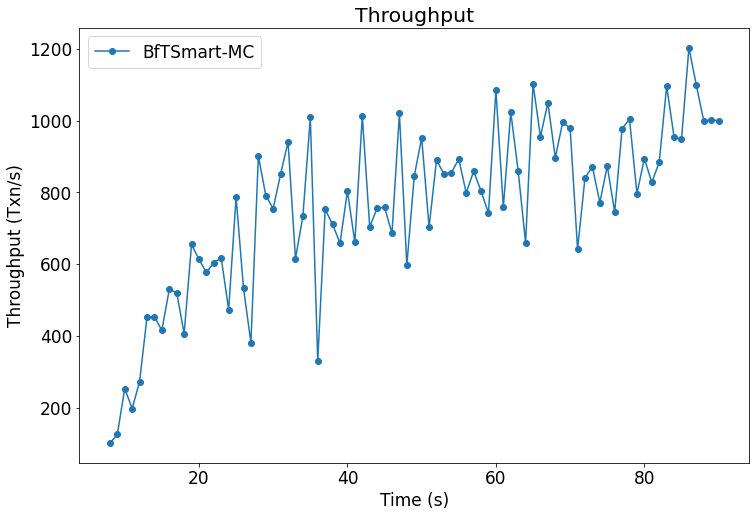

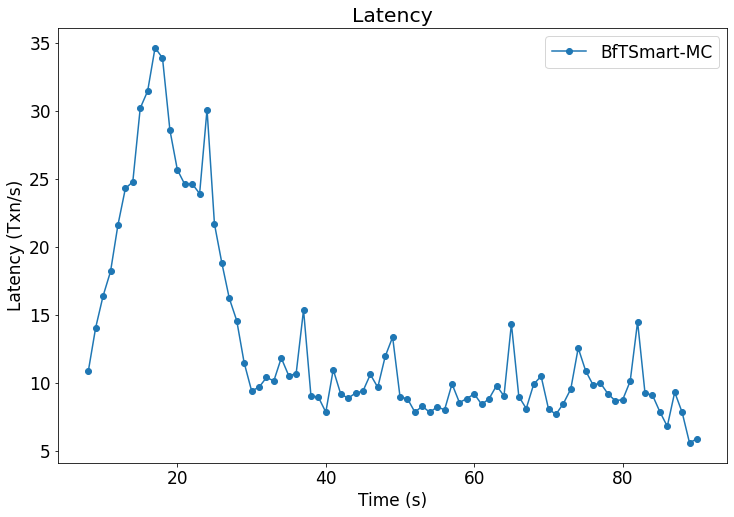

In [21]:
times_thputsDict = {}
times_latsDict = {}

for ip in clientIps[:1]:    
    i = lines.index(ip)
    
    times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
    for i in range(len(times)):
        times_thputsDict[times[i]] = thputs[i]
        times_latsDict[times[i]] = lats[i]
        

for ip in clientIps[1:]:    
    i = lines.index(ip)
    
    times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
    for i in range(len(times)):
        
        if times[i] in times_thputsDict.keys():
            times_thputsDict[times[i]] += thputs[i]
            
        if times[i] in times_latsDict.keys():
            times_latsDict[times[i]] += lats[i]
    

PIK = '../Experiments/'+experiment+"/pickle.dat"

data = [times_thputsDict, times_latsDict]

with open(PIK, "wb") as f:
    pickle.dump(data, f)


data2 = []
with open(PIK, "rb") as f:
    data2 =  pickle.load(f)


dict1 = data2[0]
dict2 = data2[1]



times1 = np.array(list(dict1.keys()))
thputs = np.array(list(dict1.values()))

times2 = np.array(list(dict2.keys()))
lats = np.array(list(dict2.values()))

times1

import pylab as pl

pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


pl.title(r'Throughput')


pl.xlabel('Time (s)')
pl.ylabel('Throughput (Txn/s)')
pl.legend()
pl.savefig('../Experiments/'+experiment+'/out.png', dpi = 150)
pl.show()




pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times1[:], lats[:], '-o', label='BfTSmart-MC')


pl.title(r'Latency')


pl.xlabel('Time (s)')
pl.ylabel('Latency (Txn/s)')
pl.legend()
pl.savefig('../Experiments/'+experiment+'/out.png', dpi = 150)
pl.show()

In [22]:
np.sum(thputs)

63010.59

In [23]:
# np.average(lats[-50:]), np.average(thputs[-50:]) # (0.0542783668, 166.87759999999997)

In [24]:
# ## Main Job

# # os.system('git add .; git commit -m "test";git push')

# experiment = 'RemoveViewChangeBftSmartMC'


# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# # print(results) 




# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# # print(results)  


# print('XXXXXXXX Started Servers XXXXXXXXXXXX')

# time.sleep(40)

# check_node(7)



# print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# time.sleep(125)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# if not os.path.exists('../Experiments/'+experiment):
#     os.mkdir('../Experiments/'+experiment)

# os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')

# for ip in nodeIps:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
# #         print(command)
#         os.system(command)

        
# for ip in no_cluster_yet_nodes:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        

# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out'
#         print(command)
#         os.system(command)

# times_thputsDict = {}
# times_latsDict = {}

# for ip in clientIps[:1]:    
#     i = lines.index(ip)
    
#     times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
#     for i in range(len(times)):
#         times_thputsDict[times[i]] = thputs[i]
#         times_latsDict[times[i]] = lats[i]
        

# for ip in clientIps[1:]:    
#     i = lines.index(ip)
    
#     times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
#     for i in range(len(times)):
        
#         if times[i] in times_thputsDict.keys():
#             times_thputsDict[times[i]] += thputs[i]
            
#         if times[i] in times_latsDict.keys():
#             times_latsDict[times[i]] += lats[i]
    

# PIK = '../Experiments/'+experiment+"/pickle.dat"

# data = [times_thputsDict, times_latsDict]

# with open(PIK, "wb") as f:
#     pickle.dump(data, f)


# data2 = []
# with open(PIK, "rb") as f:
#     data2 =  pickle.load(f)


# dict1 = data2[0]
# dict2 = data2[1]



# times1 = np.array(list(dict1.keys()))
# thputs = np.array(list(dict1.values()))

# times2 = np.array(list(dict2.keys()))
# lats = np.array(list(dict2.values()))

# times1


# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Remote View Change for BftSmart-MC with timeout = 20 s')


# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('../Experiments/'+experiment+'/out.png', dpi = 150)
# pl.show()

In [25]:
# ## Main Job

# # os.system('git add .; git commit -m "test";git push')

# experiment = 'NonLeaderFailure'


# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# # print(results) 




# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# # print(results)  


# print('XXXXXXXX Started Servers XXXXXXXXXXXX')

# time.sleep(40)

# check_node(7)



# print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# time.sleep(85)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in [3])
# time.sleep(45)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# if not os.path.exists('../Experiments/'+experiment):
#     os.mkdir('../Experiments/'+experiment)

# os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')

# for ip in nodeIps:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
# #         print(command)
#         os.system(command)

        
# for ip in no_cluster_yet_nodes:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        

# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out'
#         print(command)
#         os.system(command)

# times_thputsDict = {}
# times_latsDict = {}

# for ip in clientIps[:1]:    
#     i = lines.index(ip)
    
#     times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
#     for i in range(len(times)):
#         times_thputsDict[times[i]] = thputs[i]
#         times_latsDict[times[i]] = lats[i]
        

# for ip in clientIps[1:]:    
#     i = lines.index(ip)
    
#     times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
#     for i in range(len(times)):
        
#         if times[i] in times_thputsDict.keys():
#             times_thputsDict[times[i]] += thputs[i]
            
#         if times[i] in times_latsDict.keys():
#             times_latsDict[times[i]] += lats[i]
    

# PIK = '../Experiments/'+experiment+"/pickle.dat"

# data = [times_thputsDict, times_latsDict]

# with open(PIK, "wb") as f:
#     pickle.dump(data, f)


# data2 = []
# with open(PIK, "rb") as f:
#     data2 =  pickle.load(f)


# dict1 = data2[0]
# dict2 = data2[1]



# times1 = np.array(list(dict1.keys()))
# thputs = np.array(list(dict1.values()))

# times2 = np.array(list(dict2.keys()))
# lats = np.array(list(dict2.values()))

# times1

# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Throughput')


# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('../Experiments/'+experiment+'/out.png', dpi = 150)
# pl.show()

In [26]:
# experiment = 'NonLeaderFailure'

# PIK = '../Experiments/'+experiment+"/pickle.dat"

# data2 = []
# with open(PIK, "rb") as f:
#     data2 =  pickle.load(f)


# dict1 = data2[0]
# dict2 = data2[1]



# times1 = np.array(list(dict1.keys()))
# thputs = np.array(list(dict1.values()))

# times2 = np.array(list(dict2.keys()))
# lats = np.array(list(dict2.values()))

# times1

# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')
# pl.axvline(x=85.48, ls='--', color = 'red')

# pl.title(r'Throughput')


# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('../Experiments/'+experiment+'/out.png', dpi = 150)
# pl.show()

In [27]:
# ## Main Job

# # os.system('git add .; git commit -m "test";git push')

# experiment = 'LeaderFailure'


# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# # print(results) 




# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# # print(results)  


# print('XXXXXXXX Started Servers XXXXXXXXXXXX')

# time.sleep(40)

# check_node(7)



# print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# time.sleep(85)

# # results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in [0])
# time.sleep(100)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# if not os.path.exists('../Experiments/'+experiment):
#     os.mkdir('../Experiments/'+experiment)

# os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')

# for ip in nodeIps:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
# #         print(command)
#         os.system(command)

        
# for ip in no_cluster_yet_nodes:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        

# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out'
#         print(command)
#         os.system(command)

# times_thputsDict = {}
# times_latsDict = {}

# for ip in clientIps[:1]:    
#     i = lines.index(ip)
    
#     times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
#     for i in range(len(times)):
#         times_thputsDict[times[i]] = thputs[i]
#         times_latsDict[times[i]] = lats[i]
        

# for ip in clientIps[1:]:    
#     i = lines.index(ip)
    
#     times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
#     for i in range(len(times)):
        
#         if times[i] in times_thputsDict.keys():
#             times_thputsDict[times[i]] += thputs[i]
            
#         if times[i] in times_latsDict.keys():
#             times_latsDict[times[i]] += lats[i]
    

# PIK = '../Experiments/'+experiment+"/pickle.dat"

# data = [times_thputsDict, times_latsDict]

# with open(PIK, "wb") as f:
#     pickle.dump(data, f)


# data2 = []
# with open(PIK, "rb") as f:
#     data2 =  pickle.load(f)


# dict1 = data2[0]
# dict2 = data2[1]



# times1 = np.array(list(dict1.keys()))
# thputs = np.array(list(dict1.values()))

# times2 = np.array(list(dict2.keys()))
# lats = np.array(list(dict2.values()))

# times1

# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Throughput')


# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('../Experiments/'+experiment+'/out.png', dpi = 150)
# pl.show()

In [28]:

# def join_node1(i):
#     ip = lines[i]
#     if ip!='None':
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 8 172.31.24.233 11080 11081 config0 >../nohup_j1.out 2>&1 &"'
        
        
#         os.system(command)   
        
        
# def join_node2(i):
#     ip = lines[i]
#     if ip!='None':
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 9 172.31.19.58 11090 11091 config0 >../nohup_j2.out 2>&1 &"'
        
        
#         os.system(command)
        
        
# def join_node3(i):
#     ip = lines[i]
#     if ip!='None':
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 10 172.31.29.208 11100 11101 config0 >../nohup_j1.out 2>&1 &"'
        
        
#         os.system(command)   
        
        
# def join_node4(i):
#     ip = lines[i]
#     if ip!='None':
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 11 172.31.25.228 11110 11111 1 config1 >../nohup_j2.out 2>&1 &"'
        
        
#         os.system(command)           

# # join_node1(11), join_node2(11)

# # time.sleep(30)
# # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# # time.sleep(45)
# # print(results)  

# # time.sleep(45)
# # join_node1(11)
# # time.sleep(45)

# # join_node1(11)
# # time.sleep(45)



# print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# time.sleep(85)



# # join_node1(11)
# # time.sleep(85)


# # join_node2(11)
# # time.sleep(85)




# # results = Parallel(n_jobs=len(lines))(delayed(kill_clients)(i) for i in range(len(lines)))
# # time.sleep(25)



# # print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# # time.sleep(20)


# # def join_node1_check(i):
# #     ip = lines[i]
# #     if ip!='None':
        
# #         current = (ip.split('.'))
# #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
# #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 8 172.31.24.46 11080 11081 config0 >../nohup_j1.out 2>&1 &"'
        
        
# #         print(command)   
        

# # join_node1_check(11)


# # results = Parallel(n_jobs=len(lines))(delayed(kill_clients)(i) for i in range(len(lines)))
# # time.sleep(5)


# # join_node2(11)
# # time.sleep(45)


# # print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# # time.sleep(45)




# # join_node2(11)
# # time.sleep(45)




# # join_node3(13)
# # time.sleep(40)
# # join_node4(13)
# # time.sleep(40)

# # time.sleep(50)
# check_node(10)

# # time.sleep(100)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# if not os.path.exists('../Experiments/'+experiment):
#     os.mkdir('../Experiments/'+experiment)

# for ip in nodeIps:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
# #         print(command)
#         os.system(command)

        
# for ip in no_cluster_yet_nodes:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        

# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'
#         print(command)
#         os.system(command)
        
        
        
# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'
#         print(command)
#         os.system(command)
        
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_j1.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_j1.out'
#         print(command)
#         os.system(command)
        
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_j2.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_j2.out'
#         print(command)
#         os.system(command)        

# ## Byzantine Remote View Change

# times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_c4_11.out')

# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Throughput with Byzantine Remote View Change ($nz$=8)')

# # pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# # pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('../Experiments/RemoteViewChange.png', dpi = 150)
# pl.show()
# pl.clf()


# ## Join End for Checking

# times_all_clients = []
# ops_all_clients = []
# thputs_all_clients = []
# latencies_all_clients = []


# for ip in clientIps:
#     print(lines.index(ip), nreplicas)
    
    
#     with open('../Experiments/'+experiment+'/'+'nohup_c'+str(nreplicas)+'_'+str(lines.index(ip))+'.out') as f:
#         data = f.readlines()
        
    
    

#     times = []
#     ops = []
#     thputs = []
#     latencies = []



#     for line in data:
#         if 'current ops/sec' in line:
#     #         print(line)

#             numbers_string = line.replace('sec:', ':').replace('operations;', ':').replace(\
#                     'current ops/sec; [UPDATE AverageLatency(us)=', ':').replace('] \n', '').replace(' ','')

        
#             if len(numbers_string.split(':')) == 4:

#                 times.append(float(numbers_string.split(':')[0]))
#                 ops.append(float(numbers_string.split(':')[1]))    
#                 thputs.append(float(numbers_string.split(':')[2]))    
#                 latencies.append(float(numbers_string.split(':')[3])/1e6)    



#     times = np.array(times)
#     ops = np.array(ops)
#     thputs = np.array(thputs)
#     latencies = np.array(latencies)
    
#     times_all_clients.append(times)
#     ops_all_clients.append(ops)    
#     thputs_all_clients.append(thputs)    
#     latencies_all_clients.append(latencies)    

# times_all_clients


# times_all_clients_final = []
# ops_all_clients_final = []
# thputs_all_clients_final = []
# latencies_all_clients_final = []

# for iter_, item in enumerate(times_all_clients):
    

#     np.array(list(set(item).intersection(*times_all_clients[:])))
#     # index = in1d(times_all_clients[0],a1)
#     # result = a2[index]

#     both = set(item).intersection(np.array(list(set(item).intersection(*times_all_clients[:]))))

#     indices_A = [list(item).index(x) for x in list(both)]
#     indices_B = [list(set(item).intersection(*times_all_clients[:])).index(x) for x in both]

#     times_all_clients_final.append(item[indices_A])
#     ops_all_clients_final.append(ops_all_clients[iter_][indices_A])
#     thputs_all_clients_final.append(thputs_all_clients[iter_][indices_A])    
#     latencies_all_clients_final.append(latencies_all_clients[iter_][indices_A])    

# times_all = times_all_clients_final[0]
# ops_all = sum(ops_all_clients_final)
# thputs_all = sum(thputs_all_clients_final)
# latencies_all = sum(latencies_all_clients_final)/len(latencies_all_clients_final)


# print('Average Throughput is ',(ops_all[-1] - ops_all[59])/(times_all[-1] - times_all[59]))

# print('Average Latency is', np.average(latencies_all[60:-10]))

# times_all, thputs_all

# # 40 client threads 2 delivery:93+95/81
# # 100 client threads 2 delivery:124+129/81
# # 100 client threads 8 delivery:138+138/81
# # 40 client threads 8 delivery:95+95/81
# # 40 client threads 16 delivery:97+96/81
# # 40 client threads 16 delivery without IO:93+93/81
# # 100 client threads 16 delivery without IO:146+149/81




# (146+149)/81

# check_node(0)

# for i in [0,1, 4, 14, 15]:
# # for i in [1]:
    
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../nohup_c4_'+str(i)+'.out'


#         os.system(command)

# ## Join Experiment

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))



# # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))



# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# # print(results) 



# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# # print(results)  

# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# # print(results)  



# # time.sleep(30)
# # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# # print(results)  


# # time.sleep(80)
# # results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# # for i in [0,1,4,8,12,13,14]:
# # # for i in [1]:
    
# #     ip = lines[i]
# #     if ip!='None':
# #         current = (ip.split('.'))
# #         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
# #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../nohup'+str(i)+'.out'


# #         os.system(command)

# check_node(11)

# portStart = 11000 + len(nodeIps)*10

# join_lines = []
# currentPort = portStart

# for i in range(len(no_cluster_yet_nodes)):
#     line = str(len(nodeIps)+i) + ' ' + no_cluster_yet_nodes[i] + ' ' + str(currentPort) + ' '+ str(currentPort+1)
#     currentPort = currentPort + 10
#     join_lines.append(line)
#     print('server',line)

# ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 8 172.31.31.236 11080 11081 config0
# ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 9 172.31.23.57 11090 11091 config1

# ## KILL ALL JAVA



# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))
# print(results)  

# ## JOIN COMMAND





# def run_join_client(i):
    
    
    
#     ip = lines[-2]
#     if ip!='None':
#         current = (ip.split('.'))
        
#         join_commands = join_command(i)
        
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmarto; '+join_commands+'"'
        
#         print(command)
#         os.system(command)

# ## JOIN EXPERIMENT

# check_node(3)

# # t1 = time.time()
# # time.sleep(3)
# # t2 = time.time()

# import time
# JoinTimes = []


# t_start = time.time()

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# print(results)  

# check_node(9)

# time.sleep(40)

# for i in range(4,8):
#     print(i)
#     JoinTimes.append(time.time() - t_start)
#     run_join_client(i)
#     time.sleep(40)
    

# check_node(7)


# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))
# print(results)  

# ip

# ip = lines[-1]
# if ip!='None':
#     current = (ip.split('.'))
#     command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#           +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out data/MultipleJoins/nohup.out'


#     os.system(command)




# import numpy as np
# import pylab as pl

# times ,thputs, lats = getTimesThputs('data/MultipleJoins/nohup.out')

# JoinTimes

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:-10], thputs[:-10], '-o', label='Existing nodes')


# pl.title(r'Throughput with multiple join requests for Bft-Smart ($nz$=4)')

# pl.axvline(JoinTimes[0], label = '1st join', ls = '--', color = 'r')
# pl.axvline(JoinTimes[1], label = '2nd join', ls = '--', color = 'g')
# pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('StatsPaper/fig10.png', dpi = 150)
# pl.show()
# pl.clf()



# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:-10], lats[:-10], '-o', label='Existing nodes')


# pl.title(r'Latency with multiple join requests for Bft-Smart ($nz$=4)')

# # pl.axvline(JoinTimes[0], label = '1st join', ls = '--', color = 'r')
# # pl.axvline(JoinTimes[1], label = '2nd join', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# # pl.ylabel(r'Latency ($\mu$s)')
# pl.legend()
# # pl.savefig('StatsPaper/fig10.png', dpi = 150)
# pl.show()
# pl.clf()

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:-10], thputs[:-10]*lats[:-10], '-o', label='Existing nodes')


# pl.title(r'Latency*thput with multiple join requests for Bft-Smart ($nz$=4)')

# # pl.axvline(JoinTimes[0], label = '1st join', ls = '--', color = 'r')
# # pl.axvline(JoinTimes[1], label = '2nd join', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel(r'Latency ($\mu$s)')
# pl.legend()
# # pl.savefig('StatsPaper/fig10.png', dpi = 150)
# pl.show()
# pl.clf()

# ## Random Failure

# os.system('git add .; git commit -m "Fixed Failures and Joins";git push')

# experiment = 'bjoin'


# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))


# # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# # print(results) 




# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# # print(results)  

# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# # print(results)  


# print('XXXXXXXX Started Servers XXXXXXXXXXXX')

# time.sleep(40)

# check_node(7)



# def fail_node(i):
#     ip = lines[i]
#     if ip!='None' and ip in nodeIps:
#         current = (ip.split('.'))
                
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmartt; sudo killall java"'
        
#         print(command)
#         os.system(command)

# import numpy as np
# import random

# import time
# # time.sleep(10)

# FailTimes = []


# t_start = time.time()

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# print(results)  

# check_node(9)

# time.sleep(45)

# for i in random.sample(list(np.arange(1)), 1):
#     print(i)
#     FailTimes.append(time.time() - t_start)
#     fail_node(0)
#     time.sleep(85)
    

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# ip = lines[-1]
# if ip!='None':
#     current = (ip.split('.'))
#     command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#           +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/nohup.out'

#     print(command)
#     os.system(command)

# FailTimes

# times ,thputs, lats = getTimesThputs('../Experiments/nohup.out')

# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Throughput with single leader failure ($nz$=8)')

# pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# # pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# # pl.savefig('../Experiments/fig6_leader.png', dpi = 150)
# pl.show()
# pl.clf()


# if not os.path.exists('../Experiments/'+experiment):
#     os.mkdir('../Experiments/'+experiment)

# for ip in nodeIps:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
# #         print(command)
#         os.system(command)

        
# for ip in no_cluster_yet_nodes:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        

# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'
#         print(command)
#         os.system(command)
        
        
        
# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'
#         print(command)
#         os.system(command)
        
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_j1.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_j1.out'
#         print(command)
#         os.system(command)
        
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_j2.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_j2.out'
#         print(command)
#         os.system(command)        

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))